# Imports

In [1]:
#!/usr/bin/env python3

import numpy as np
import sklearn as sk
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from sklearn import metrics
import gc
import time


from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

import seaborn as sns
from pylab import rcParams
import pickle
from sklearn import metrics
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

from pyod.utils.example import visualize
import warnings
import matplotlib.font_manager
warnings.filterwarnings("ignore")

# Data Load

In [2]:
df = pd.read_csv('/Volumes/C/Thesis-2019/cluster-output/DG_out.csv', sep=',')
df.head()

tx_hash  indegree  outdegree  \
0  0437cd7f8525ceed2324359c2d0ba26006d92d856a9c20...         0          1   
1  f4184fc596403b9d638783cf57adfe4c75c605f6356fbc...         1          2   
2  ea44e97271691990157559d0bdd9959e02790c34db6c00...         1          1   
3  a16f3ce4dd5deb92d98ef5cf8afeaf0775ebca408f708b...         1          1   
4  591e91f809d716912ca1d4a9295e70c3e78bab077683f7...         1          2   

   in_btc  out_btc  total_btc  mean_in_btc  mean_out_btc  in_malicious  \
0     0.0     50.0       50.0          0.0          50.0             0   
1    50.0     50.0      100.0         50.0          25.0             0   
2    10.0     10.0       20.0         10.0          10.0             0   
3    40.0     30.0       70.0         40.0          30.0             0   
4    30.0     30.0       60.0         30.0          15.0             0   

   out_malicious  is_malicious  out_and_tx_malicious  all_malicious  
0              0             0                     0              0  
1              0             0                     0              0  
2              0             0                     0              0  
3              0             0                     0              0  
4              0             0                     0              0

In [3]:
df.drop('tx_hash', axis=1, inplace=True)
df.drop('in_malicious', axis=1, inplace=True)
df.drop('out_malicious', axis=1, inplace=True)
df.drop('is_malicious', axis=1, inplace=True)
df.drop('all_malicious', axis=1, inplace=True)

# df.drop('in_btc', axis=1, inplace=True)
# df.drop('out_btc', axis=1, inplace=True)
# df.drop('total_btc', axis=1, inplace=True)
# df.drop('mean_in_btc', axis=1, inplace=True)
# df.drop('mean_out_btc', axis=1, inplace=True)


df.describe()

indegree     outdegree        in_btc       out_btc     total_btc  \
count  3.024813e+07  3.024813e+07  3.024813e+07  3.024813e+07  3.024813e+07   
mean   2.148699e+00  2.148699e+00  5.484150e+01  5.484150e+01  1.096830e+02   
std    7.421447e+00  4.512048e+00  1.303303e+03  1.301473e+03  2.602527e+03   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.000000e+00  2.000000e+00  1.000000e-01  9.950000e-02  2.058720e-01   
50%    1.000000e+00  2.000000e+00  9.325000e-01  9.590000e-01  1.964759e+00   
75%    2.000000e+00  2.000000e+00  8.591912e+00  9.063657e+00  1.840000e+01   
max    1.932000e+03  1.322000e+03  5.500000e+05  5.000207e+05  1.050000e+06   

        mean_in_btc  mean_out_btc  out_and_tx_malicious  
count  3.024813e+07  3.024813e+07          3.024813e+07  
mean   4.923980e+01  2.877087e+01          3.570468e-06  
std    9.729210e+02  7.125567e+02          1.889565e-03  
min    0.000000e+00  0.000000e+00          0.000000e+00  
25%    6.400000e-02  5.025776e-02          0.000000e+00  
50%    5.350261e-01  4.900000e-01          0.000000e+00  
75%    5.614287e+00  4.519481e+00          0.000000e+00  
max    4.992596e+05  5.000000e+05          1.000000e+00

In [4]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['out_and_tx_malicious'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['out_and_tx_malicious'].value_counts()[1]/len(df) * 100,5), '% of the dataset')

No Frauds 100.0 % of the dataset
Frauds 0.00036 % of the dataset


In [5]:
df['out_and_tx_malicious'].value_counts()

0    30248026
1         108
Name: out_and_tx_malicious, dtype: int64

# Scale transform

In [6]:
# Log scale to normalize the data
scaled_df = df.copy()

scaled_df['indegree'] = np.log1p(scaled_df['indegree'])
scaled_df['outdegree']= np.log1p(scaled_df['outdegree'])
scaled_df['in_btc'] = np.log1p(scaled_df['in_btc'])
scaled_df['out_btc']= np.log1p(scaled_df['out_btc'])
scaled_df['total_btc']= np.log1p(scaled_df['total_btc'])
scaled_df['mean_in_btc']= np.log1p(scaled_df['mean_in_btc'])
scaled_df['mean_out_btc']= np.log1p(scaled_df['mean_out_btc'])

# RobustScaler is less prone to outliers.
from sklearn.preprocessing import RobustScaler
rob_scaler = RobustScaler()

scaled_df['indegree'] = rob_scaler.fit_transform(scaled_df['indegree'].values.reshape(-1,1))
scaled_df['outdegree'] = rob_scaler.fit_transform(scaled_df['outdegree'].values.reshape(-1,1))
scaled_df['in_btc'] = rob_scaler.fit_transform(scaled_df['in_btc'].values.reshape(-1,1))
scaled_df['out_btc'] = rob_scaler.fit_transform(scaled_df['out_btc'].values.reshape(-1,1))
scaled_df['total_btc'] = rob_scaler.fit_transform(scaled_df['total_btc'].values.reshape(-1,1))
scaled_df['mean_in_btc'] = rob_scaler.fit_transform(scaled_df['mean_in_btc'].values.reshape(-1,1))
scaled_df['mean_out_btc'] = rob_scaler.fit_transform(scaled_df['mean_out_btc'].values.reshape(-1,1))

In [7]:
del df #free memory
gc.collect()

44

# Split

In [8]:
original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(scaled_df.iloc[:,:-1], scaled_df['out_and_tx_malicious'], test_size = 0.20, random_state=10)

In [9]:
pd.value_counts(original_ytrain)

0    24198425
1          82
Name: out_and_tx_malicious, dtype: int64

In [10]:
pd.value_counts(original_ytest)

0    6049601
1         26
Name: out_and_tx_malicious, dtype: int64

In [11]:
del scaled_df #free memory
gc.collect()

55

# Get Training Sample

In [12]:
from sklearn.utils import shuffle

original_train_df = pd.concat([original_Xtrain, original_ytrain], axis=1)
original_train_normal_df = original_train_df[original_train_df.out_and_tx_malicious == 0]
original_train_fraud_df = original_train_df[original_train_df.out_and_tx_malicious == 1]

def get_training_sample(n):
    normal_sample = original_train_normal_df.sample(n)
    final_sample = pd.concat([normal_sample, original_train_fraud_df])
    final_sample = shuffle(final_sample)

    return final_sample.iloc[:,:-1].values, final_sample.iloc[:,-1].values

# Get Test Sample

In [13]:
original_test_df = pd.concat([original_Xtest, original_ytest], axis=1)
original_test_normal_df = original_test_df[original_test_df.out_and_tx_malicious == 0]
original_test_fraud_df = original_test_df[original_test_df.out_and_tx_malicious == 1]

def get_test_sample(n):
    normal_sample = original_test_normal_df.sample(n)
    final_sample = pd.concat([normal_sample, original_test_fraud_df])
    final_sample = shuffle(final_sample)
    return final_sample.iloc[:,:-1].values, final_sample.iloc[:,-1].values

# Oversample Training Data

In [14]:
from imblearn.over_sampling import SMOTE

def oversample_minority_class(X, y, fraction):
    SM = SMOTE(fraction, n_jobs=-1)
    return SM.fit_resample(X, y)

# Evaluation Metrics

In [15]:
def evaluate(actual, predicted, probability, time_complexity):
    eval_metric = {}
    eval_metric['time'] = time_complexity
    eval_metric['conf_matrix'] = confusion_matrix(actual, predicted)
    
    eval_metric['balanced_accuracy'] = round(balanced_accuracy_score(actual, predicted),7)
    eval_metric['accuracy'] = round(accuracy_score(actual, predicted),7)
    
    eval_metric['macro_precision'] = round(precision_score(actual, predicted, average="macro"),7)
    eval_metric['macro_recall'] = round(recall_score(actual,predicted, average="macro"),7)
    eval_metric['macro_f1'] = round(f1_score(actual,predicted, average="macro"),7)
    eval_metric['macro_roc'] = round(roc_auc_score(actual, probability, average="macro"),7)

    
    eval_metric['precision'] = round(precision_score(actual, predicted),7)
    eval_metric['recall'] = round(recall_score(actual,predicted),7)
    eval_metric['f1'] = round(f1_score(actual,predicted),7)
    eval_metric['roc'] = round(roc_auc_score(actual, probability),7)

    false_pos_rate, true_pos_rate, thresholds = roc_curve(actual, probability)
    eval_metric['false_pos_rate'] = false_pos_rate
    eval_metric['true_pos_rate'] = true_pos_rate
    eval_metric['thresholds'] = thresholds
    
    precision_rt, recall_rt, threshold_rt = precision_recall_curve(actual, probability)
    eval_metric['precision_rt'] = precision_rt
    eval_metric['recall_rt'] = recall_rt
    eval_metric['threshold_rt'] = threshold_rt
    return eval_metric

# Save Model

In [19]:
model_path = './Models/CBLOF/'

def save_model(model, path):
    pickle.dump(model, open(path, 'wb'))

# Fit Model

In [22]:
from pyod.models.cblof import CBLOF

iterations = 20
random_state = 42
training_sample_size = int(len(original_ytrain) / 10)
oversampling_fraction = 0.2356
outliers_fraction = oversampling_fraction

print('Training Parameters:\n====================\n')
print('Iterations: '+ str(iterations))
print('Training Sample Size: '+ str(training_sample_size))
print('Oversampling Fraction: '+ str(oversampling_fraction))
print('Outliers Fraction: '+ str(outliers_fraction))

#best: {'alpha': 0.8394485188873344, 'beta': 2.090218289939831, 'n_clusters': 7.899400867394069, 'outliers_fraction': 0.23561901292786977}

def fit_model(X_train):
    clf = CBLOF(n_clusters=8, contamination=outliers_fraction, clustering_estimator=None, alpha=0.839, beta=2, use_weights=False, check_estimator=False, random_state=random_state, n_jobs=-1)
    clf.fit(X_train)
    return clf

Training Parameters:

Iterations: 20
Training Sample Size: 2419850
Oversampling Fraction: 0.2356
Outliers Fraction: 0.2356


# Iterative Modeling

In [23]:
training_evaluations = {}
test_evaluations = {}
model = {}

for i in range(0, iterations):
    sample_Xtrain, sample_ytrain = get_training_sample(training_sample_size)
    X_train, y_train = oversample_minority_class(sample_Xtrain, sample_ytrain, oversampling_fraction)
    print("Iteration "+ str(i+1)+ " in progress...")

    #Modeling
    start = time.time()
    clf = fit_model(X_train)
    end = time.time()
    save_model(clf, model_path+'i='+str(i+1)+'.h5')
    # get the prediction labels and outlier scores of the training data
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores

    training_time = round(end - start, 4)
    model[i+1] = clf
    training_evaluations[i+1] = evaluate(y_train, y_train_pred, y_train_scores, training_time)
    
    print("Iteration "+ str(i+1)+ " Trained")

    test_start = time.time()
    y_test_pred = clf.predict(original_Xtest)
    y_test_scores = clf.decision_function(original_Xtest)
    test_end = time.time()
    testing_time = round(test_end - test_start, 4)
    test_evaluations[i+1] = evaluate(original_ytest, y_test_pred, y_test_scores, testing_time)

    print("Iteration: (" + str((i+1)) + "/" + str(iterations) + ")    Training Time: "+str(training_time)+" seconds     Testing Time: "+ str(testing_time)+ " seconds")

print("Iterative Modeling Completed!")

Iteration 1 in progress...
Iteration 1 Trained
Iteration: (1/20)    Training Time: 49.8873 seconds     Testing Time: 5.1392 seconds
Iteration 2 in progress...
Iteration 2 Trained
Iteration: (2/20)    Training Time: 46.7029 seconds     Testing Time: 4.9829 seconds
Iteration 3 in progress...
Iteration 3 Trained
Iteration: (3/20)    Training Time: 47.9858 seconds     Testing Time: 5.0132 seconds
Iteration 4 in progress...
Iteration 4 Trained
Iteration: (4/20)    Training Time: 39.1775 seconds     Testing Time: 4.835 seconds
Iteration 5 in progress...
Iteration 5 Trained
Iteration: (5/20)    Training Time: 41.228 seconds     Testing Time: 4.8933 seconds
Iteration 6 in progress...
Iteration 6 Trained
Iteration: (6/20)    Training Time: 46.7367 seconds     Testing Time: 5.0782 seconds
Iteration 7 in progress...
Iteration 7 Trained
Iteration: (7/20)    Training Time: 41.7685 seconds     Testing Time: 4.8076 seconds
Iteration 8 in progress...
Iteration 8 Trained
Iteration: (8/20)    Training T

# Tabular Evaluation

In [24]:
training_eval_df = pd.DataFrame(columns=['Iteration','Accuracy','Balanced-Accuracy','Macro-Precision','Macro-Recall','Macro-F1','Macro-ROC', 'Precision', 'Recall', 'F1', 'ROC', 'Time'])
test_eval_df = pd.DataFrame(columns=['Iteration','Accuracy','Balanced-Accuracy','Macro-Precision','Macro-Recall','Macro-F1','Macro-ROC', 'Precision', 'Recall', 'F1', 'ROC', 'Time'])
for it in list(training_evaluations.keys()):
    training_eval_df = training_eval_df.append({'Iteration' : str(it),
                             'Accuracy' : training_evaluations[it]['accuracy'],
                             'Balanced-Accuracy' : training_evaluations[it]['balanced_accuracy'],
                             'Macro-Precision' : training_evaluations[it]['macro_precision'],
                             'Macro-Recall' : training_evaluations[it]['macro_recall'],
                             'Macro-F1' : training_evaluations[it]['macro_f1'],
                             'Macro-ROC' : training_evaluations[it]['macro_roc'],
                             'Precision' : training_evaluations[it]['precision'],
                             'Recall' : training_evaluations[it]['recall'],
                             'F1' : training_evaluations[it]['f1'],
                             'ROC' : training_evaluations[it]['roc'],
                             'Time' : training_evaluations[it]['time']                                              
                            }, ignore_index=True)
    
for it in list(test_evaluations.keys()):
    test_eval_df = test_eval_df.append({'Iteration' : str(it),
                             'Accuracy' : test_evaluations[it]['accuracy'],
                             'Balanced-Accuracy' : test_evaluations[it]['balanced_accuracy'],
                             'Macro-Precision' : test_evaluations[it]['macro_precision'],
                             'Macro-Recall' : test_evaluations[it]['macro_recall'],
                             'Macro-F1' : test_evaluations[it]['macro_f1'],
                             'Macro-ROC' : test_evaluations[it]['macro_roc'],
                             'Precision' : test_evaluations[it]['precision'],
                             'Recall' : test_evaluations[it]['recall'],
                             'F1' : test_evaluations[it]['f1'],
                             'ROC' : test_evaluations[it]['roc'],
                             'Time' : test_evaluations[it]['time']                                              
                            }, ignore_index=True)

In [25]:
training_eval_df.sort_values('Macro-F1', ascending=False)

Iteration  Accuracy  Balanced-Accuracy  Macro-Precision  Macro-Recall  \
2          3  0.800226           0.721385         0.689702      0.721385   
14        15  0.799950           0.720938         0.689319      0.720938   
11        12  0.799946           0.720931         0.689313      0.720931   
5          6  0.799931           0.720907         0.689292      0.720907   
6          7  0.799820           0.720727         0.689138      0.720727   
18        19  0.799788           0.720676         0.689094      0.720676   
16        17  0.799780           0.720662         0.689082      0.720662   
0          1  0.799772           0.720649         0.689071      0.720649   
12        13  0.799760           0.720630         0.689055      0.720630   
3          4  0.799732           0.720584         0.689016      0.720584   
10        11  0.799678           0.720497         0.688941      0.720497   
8          9  0.799612           0.720389         0.688849      0.720389   
13        14  0.799536           0.720268         0.688744      0.720268   
15        16  0.799524           0.720248         0.688728      0.720248   
19        20  0.799517           0.720236         0.688717      0.720236   
4          5  0.799494           0.720199         0.688686      0.720199   
17        18  0.799475           0.720166         0.688659      0.720166   
9         10  0.799406           0.720057         0.688564      0.720057   
1          2  0.797079           0.716287         0.685334      0.716287   
7          8  0.795934           0.714432         0.683744      0.714432   

    Macro-F1  Macro-ROC  Precision    Recall        F1       ROC     Time  
2   0.702203   0.758768   0.480692  0.593944  0.531351  0.758768  47.9858  
14  0.701793   0.758496   0.480108  0.593221  0.530704  0.758496  45.6294  
11  0.701786   0.758380   0.480098  0.593209  0.530693  0.758380  47.3630  
5   0.701764   0.757914   0.480066  0.593171  0.530659  0.757914  46.7367  
6   0.701598   0.758771   0.479831  0.592879  0.530398  0.758771  41.7685  
18  0.701551   0.758266   0.479764  0.592797  0.530324  0.758266  46.5725  
16  0.701538   0.758066   0.479745  0.592774  0.530304  0.758066  49.5699  
0   0.701527   0.757941   0.479729  0.592753  0.530285  0.757941  49.8873  
12  0.701508   0.758434   0.479703  0.592722  0.530257  0.758434  43.0998  
3   0.701467   0.758568   0.479643  0.592648  0.530191  0.758568  39.1775  
10  0.701387   0.758337   0.479530  0.592507  0.530065  0.758337  44.2574  
8   0.701288   0.757990   0.479389  0.592332  0.529909  0.757990  38.8703  
13  0.701175   0.757593   0.479229  0.592136  0.529733  0.757593  39.4134  
15  0.701157   0.757786   0.479203  0.592104  0.529705  0.757786  42.8584  
19  0.701147   0.757540   0.479188  0.592085  0.529687  0.757540  41.3450  
4   0.701113   0.757807   0.479139  0.592025  0.529634  0.757807  41.2280  
17  0.701083   0.757947   0.479099  0.591969  0.529587  0.757947  39.2051  
9   0.700982   0.757733   0.478953  0.591795  0.529428  0.757733  41.2255  
1   0.697513   0.760188   0.474015  0.585693  0.523969  0.760188  46.7029  
7   0.695806   0.763466   0.471584  0.582690  0.521283  0.763466  47.5644

In [26]:
training_eval_df.sort_values('ROC', ascending=False)

Iteration  Accuracy  Balanced-Accuracy  Macro-Precision  Macro-Recall  \
7          8  0.795934           0.714432         0.683744      0.714432   
1          2  0.797079           0.716287         0.685334      0.716287   
6          7  0.799820           0.720727         0.689138      0.720727   
2          3  0.800226           0.721385         0.689702      0.721385   
3          4  0.799732           0.720584         0.689016      0.720584   
14        15  0.799950           0.720938         0.689319      0.720938   
12        13  0.799760           0.720630         0.689055      0.720630   
11        12  0.799946           0.720931         0.689313      0.720931   
10        11  0.799678           0.720497         0.688941      0.720497   
18        19  0.799788           0.720676         0.689094      0.720676   
16        17  0.799780           0.720662         0.689082      0.720662   
8          9  0.799612           0.720389         0.688849      0.720389   
17        18  0.799475           0.720166         0.688659      0.720166   
0          1  0.799772           0.720649         0.689071      0.720649   
5          6  0.799931           0.720907         0.689292      0.720907   
4          5  0.799494           0.720199         0.688686      0.720199   
15        16  0.799524           0.720248         0.688728      0.720248   
9         10  0.799406           0.720057         0.688564      0.720057   
13        14  0.799536           0.720268         0.688744      0.720268   
19        20  0.799517           0.720236         0.688717      0.720236   

    Macro-F1  Macro-ROC  Precision    Recall        F1       ROC     Time  
7   0.695806   0.763466   0.471584  0.582690  0.521283  0.763466  47.5644  
1   0.697513   0.760188   0.474015  0.585693  0.523969  0.760188  46.7029  
6   0.701598   0.758771   0.479831  0.592879  0.530398  0.758771  41.7685  
2   0.702203   0.758768   0.480692  0.593944  0.531351  0.758768  47.9858  
3   0.701467   0.758568   0.479643  0.592648  0.530191  0.758568  39.1775  
14  0.701793   0.758496   0.480108  0.593221  0.530704  0.758496  45.6294  
12  0.701508   0.758434   0.479703  0.592722  0.530257  0.758434  43.0998  
11  0.701786   0.758380   0.480098  0.593209  0.530693  0.758380  47.3630  
10  0.701387   0.758337   0.479530  0.592507  0.530065  0.758337  44.2574  
18  0.701551   0.758266   0.479764  0.592797  0.530324  0.758266  46.5725  
16  0.701538   0.758066   0.479745  0.592774  0.530304  0.758066  49.5699  
8   0.701288   0.757990   0.479389  0.592332  0.529909  0.757990  38.8703  
17  0.701083   0.757947   0.479099  0.591969  0.529587  0.757947  39.2051  
0   0.701527   0.757941   0.479729  0.592753  0.530285  0.757941  49.8873  
5   0.701764   0.757914   0.480066  0.593171  0.530659  0.757914  46.7367  
4   0.701113   0.757807   0.479139  0.592025  0.529634  0.757807  41.2280  
15  0.701157   0.757786   0.479203  0.592104  0.529705  0.757786  42.8584  
9   0.700982   0.757733   0.478953  0.591795  0.529428  0.757733  41.2255  
13  0.701175   0.757593   0.479229  0.592136  0.529733  0.757593  39.4134  
19  0.701147   0.757540   0.479188  0.592085  0.529687  0.757540  41.3450

In [27]:
test_eval_df.sort_values('Macro-F1', ascending=False)

Iteration  Accuracy  Balanced-Accuracy  Macro-Precision  Macro-Recall  \
6          7  0.848902           0.789836         0.500010      0.789836   
12        13  0.848684           0.789727         0.500010      0.789727   
5          6  0.848673           0.789721         0.500010      0.789721   
3          4  0.848649           0.789709         0.500010      0.789709   
16        17  0.848617           0.789694         0.500010      0.789694   
11        12  0.848572           0.789671         0.500010      0.789671   
8          9  0.848565           0.789667         0.500010      0.789667   
4          5  0.848348           0.789559         0.500010      0.789559   
0          1  0.848344           0.789557         0.500010      0.789557   
14        15  0.848343           0.789556         0.500010      0.789556   
18        19  0.848323           0.789547         0.500010      0.789547   
13        14  0.848322           0.789546         0.500010      0.789546   
10        11  0.848317           0.789544         0.500010      0.789544   
9         10  0.848304           0.789537         0.500010      0.789537   
2          3  0.848294           0.789532         0.500010      0.789532   
17        18  0.848213           0.789491         0.500010      0.789491   
19        20  0.848201           0.789485         0.500010      0.789485   
15        16  0.848077           0.789423         0.500010      0.789423   
1          2  0.846800           0.788785         0.500010      0.788785   
7          8  0.845836           0.788303         0.500009      0.788303   

    Macro-F1  Macro-ROC  Precision    Recall        F1       ROC    Time  
6   0.459159   0.818955   0.000021  0.730769  0.000042  0.818955  4.8076  
12  0.459095   0.819560   0.000021  0.730769  0.000041  0.819560  4.8853  
5   0.459092   0.819030   0.000021  0.730769  0.000041  0.819030  5.0782  
3   0.459085   0.818928   0.000021  0.730769  0.000041  0.818928  4.8350  
16  0.459076   0.819533   0.000021  0.730769  0.000041  0.819533  4.8359  
11  0.459063   0.819083   0.000021  0.730769  0.000041  0.819083  4.7862  
8   0.459060   0.819022   0.000021  0.730769  0.000041  0.819022  4.9408  
4   0.458997   0.819270   0.000021  0.730769  0.000041  0.819270  4.8933  
0   0.458996   0.819057   0.000021  0.730769  0.000041  0.819057  5.1392  
14  0.458995   0.819055   0.000021  0.730769  0.000041  0.819055  4.8140  
18  0.458990   0.819824   0.000021  0.730769  0.000041  0.819824  5.2029  
13  0.458989   0.819066   0.000021  0.730769  0.000041  0.819066  4.9586  
10  0.458988   0.819092   0.000021  0.730769  0.000041  0.819092  5.2527  
9   0.458984   0.819079   0.000021  0.730769  0.000041  0.819079  4.9892  
2   0.458981   0.819352   0.000021  0.730769  0.000041  0.819352  5.0132  
17  0.458957   0.818937   0.000021  0.730769  0.000041  0.818937  4.8327  
19  0.458954   0.819166   0.000021  0.730769  0.000041  0.819166  4.9370  
15  0.458918   0.819653   0.000021  0.730769  0.000041  0.819653  4.9704  
1   0.458543   0.824439   0.000021  0.730769  0.000041  0.824439  4.9829  
7   0.458260   0.848228   0.000020  0.730769  0.000041  0.848228  4.9508

In [28]:
test_eval_df.sort_values('ROC', ascending=False)

Iteration  Accuracy  Balanced-Accuracy  Macro-Precision  Macro-Recall  \
7          8  0.845836           0.788303         0.500009      0.788303   
1          2  0.846800           0.788785         0.500010      0.788785   
18        19  0.848323           0.789547         0.500010      0.789547   
15        16  0.848077           0.789423         0.500010      0.789423   
12        13  0.848684           0.789727         0.500010      0.789727   
16        17  0.848617           0.789694         0.500010      0.789694   
2          3  0.848294           0.789532         0.500010      0.789532   
4          5  0.848348           0.789559         0.500010      0.789559   
19        20  0.848201           0.789485         0.500010      0.789485   
10        11  0.848317           0.789544         0.500010      0.789544   
11        12  0.848572           0.789671         0.500010      0.789671   
9         10  0.848304           0.789537         0.500010      0.789537   
13        14  0.848322           0.789546         0.500010      0.789546   
0          1  0.848344           0.789557         0.500010      0.789557   
14        15  0.848343           0.789556         0.500010      0.789556   
5          6  0.848673           0.789721         0.500010      0.789721   
8          9  0.848565           0.789667         0.500010      0.789667   
6          7  0.848902           0.789836         0.500010      0.789836   
17        18  0.848213           0.789491         0.500010      0.789491   
3          4  0.848649           0.789709         0.500010      0.789709   

    Macro-F1  Macro-ROC  Precision    Recall        F1       ROC    Time  
7   0.458260   0.848228   0.000020  0.730769  0.000041  0.848228  4.9508  
1   0.458543   0.824439   0.000021  0.730769  0.000041  0.824439  4.9829  
18  0.458990   0.819824   0.000021  0.730769  0.000041  0.819824  5.2029  
15  0.458918   0.819653   0.000021  0.730769  0.000041  0.819653  4.9704  
12  0.459095   0.819560   0.000021  0.730769  0.000041  0.819560  4.8853  
16  0.459076   0.819533   0.000021  0.730769  0.000041  0.819533  4.8359  
2   0.458981   0.819352   0.000021  0.730769  0.000041  0.819352  5.0132  
4   0.458997   0.819270   0.000021  0.730769  0.000041  0.819270  4.8933  
19  0.458954   0.819166   0.000021  0.730769  0.000041  0.819166  4.9370  
10  0.458988   0.819092   0.000021  0.730769  0.000041  0.819092  5.2527  
11  0.459063   0.819083   0.000021  0.730769  0.000041  0.819083  4.7862  
9   0.458984   0.819079   0.000021  0.730769  0.000041  0.819079  4.9892  
13  0.458989   0.819066   0.000021  0.730769  0.000041  0.819066  4.9586  
0   0.458996   0.819057   0.000021  0.730769  0.000041  0.819057  5.1392  
14  0.458995   0.819055   0.000021  0.730769  0.000041  0.819055  4.8140  
5   0.459092   0.819030   0.000021  0.730769  0.000041  0.819030  5.0782  
8   0.459060   0.819022   0.000021  0.730769  0.000041  0.819022  4.9408  
6   0.459159   0.818955   0.000021  0.730769  0.000042  0.818955  4.8076  
17  0.458957   0.818937   0.000021  0.730769  0.000041  0.818937  4.8327  
3   0.459085   0.818928   0.000021  0.730769  0.000041  0.818928  4.8350

# Visualization

### Metrics

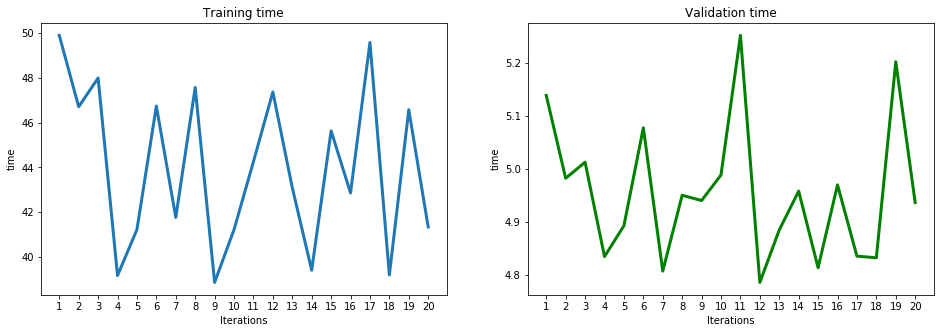

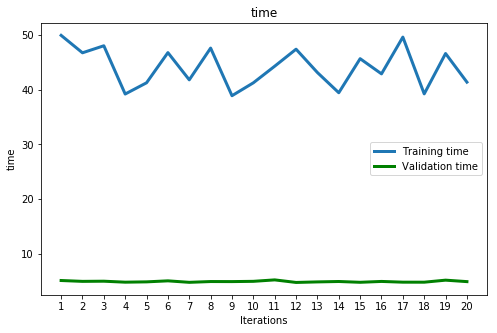

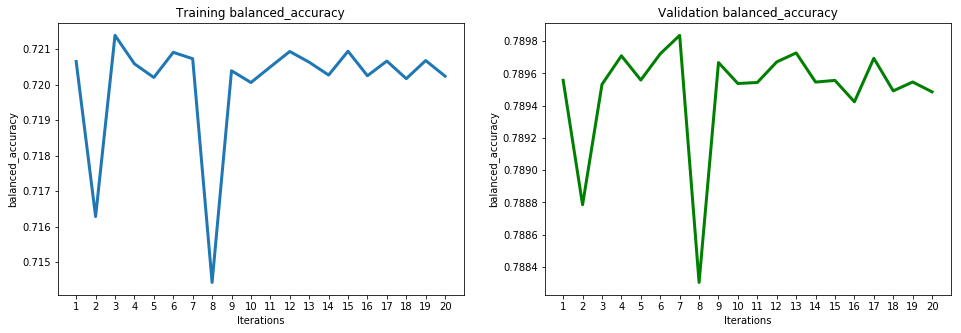

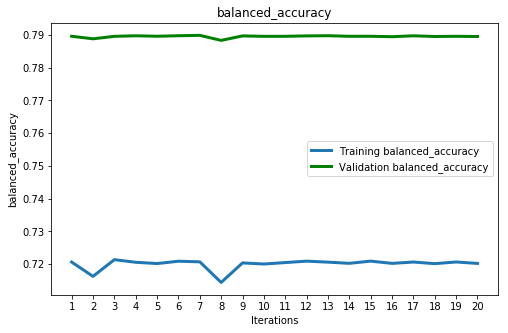

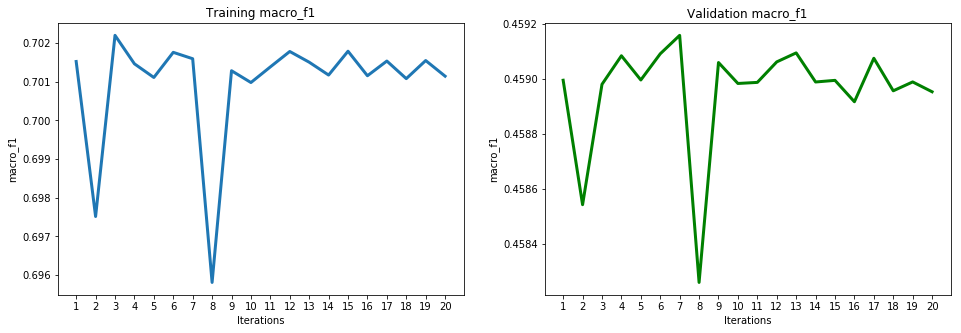

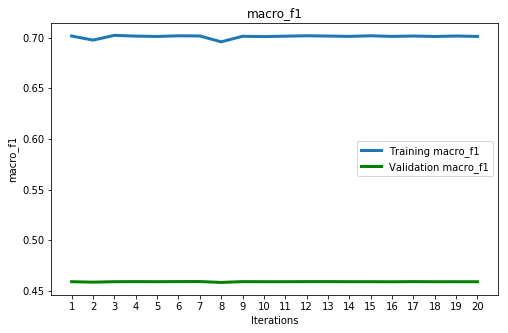

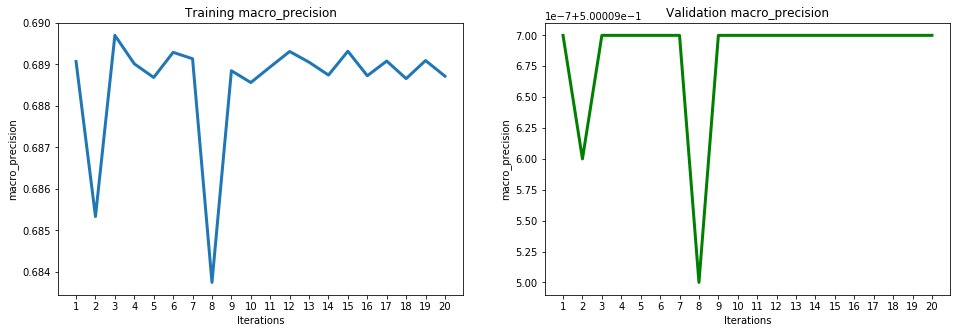

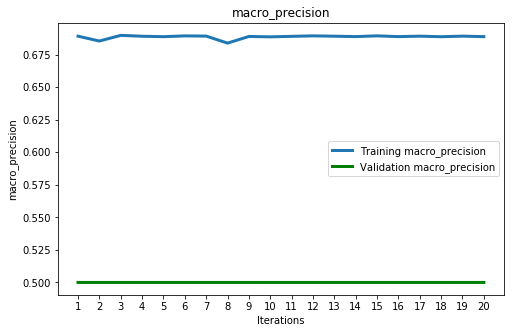

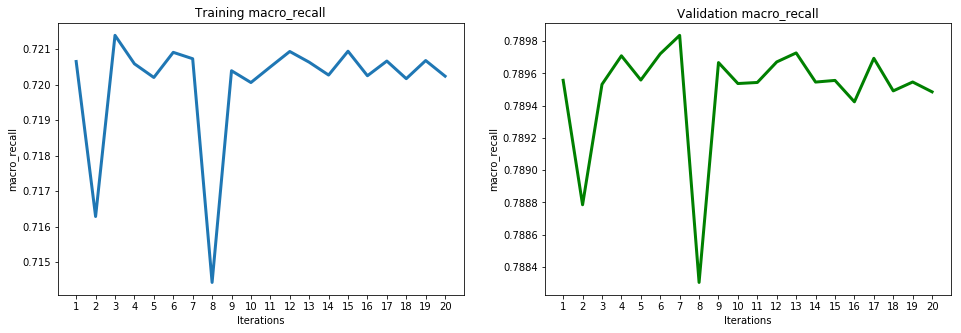

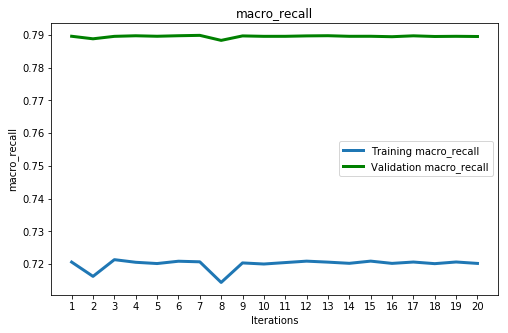

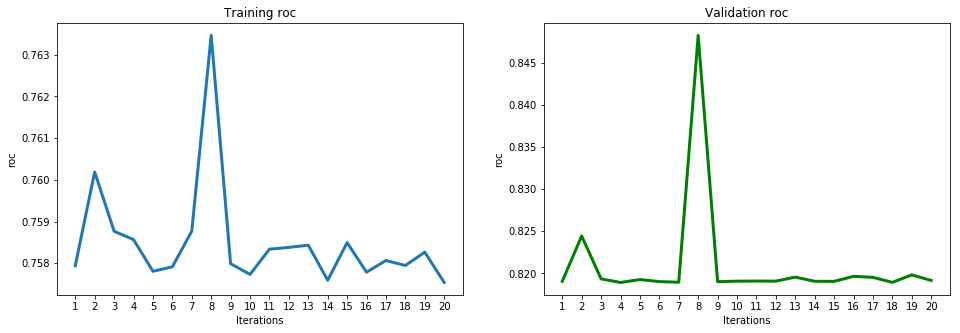

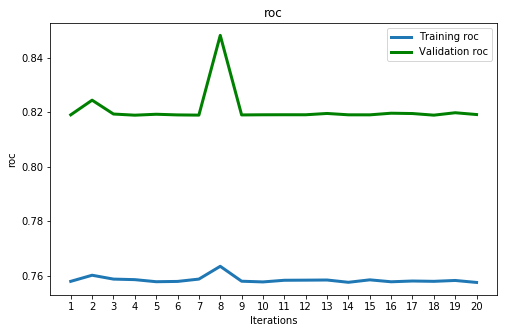

In [29]:
#metrics = ['time', 'accuracy', 'balanced_accuracy', 'f1', 'macro_f1', 'precision', 'macro_precision', 'recall', 'macro_recall', 'roc', 'macro_roc']
metrics = ['time', 'balanced_accuracy', 'macro_f1', 'macro_precision', 'macro_recall', 'roc']
for metric in metrics:    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

    iterations = list(training_evaluations.keys())
    result1 = [training_evaluations[i][metric] for i in list(training_evaluations.keys())]
    ax1.plot(iterations, result1, label="Training "+metric, linewidth=3)
    ax1.set_xticks(iterations)
    ax1.set_title('Training '+metric)
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel(metric)

    result2 = [test_evaluations[i][metric] for i in list(test_evaluations.keys())]
    ax2.plot(iterations, result2, label="Validation "+metric, linewidth=3, color='g')
    ax2.set_xticks(iterations)
    ax2.set_title('Validation '+metric)
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel(metric)

    plt.figure(1)
    iterations = list(training_evaluations.keys())
    result1 = [training_evaluations[i][metric] for i in list(training_evaluations.keys())]
    result2 = [test_evaluations[i][metric] for i in list(test_evaluations.keys())]
    plt.figure(figsize=(8, 5))
    plt.xticks(iterations)
    plt.plot(iterations, result1, label="Training "+metric, linewidth=3)
    plt.plot(iterations, result2, label="Validation "+metric, linewidth=3, color='g')
    plt.legend()
    plt.title(metric)
    plt.xlabel('Iterations')
    plt.ylabel(metric)
    plt.show()

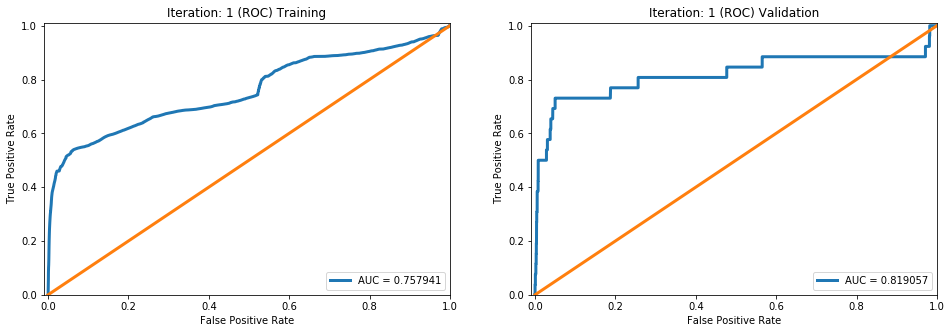

<Figure size 432x288 with 0 Axes>

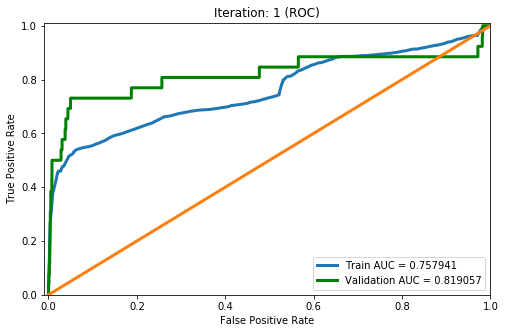

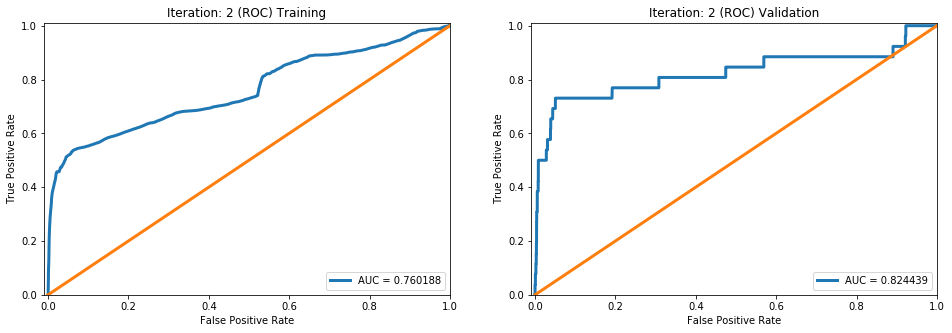

<Figure size 432x288 with 0 Axes>

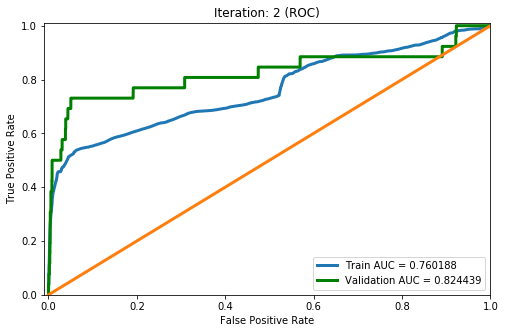

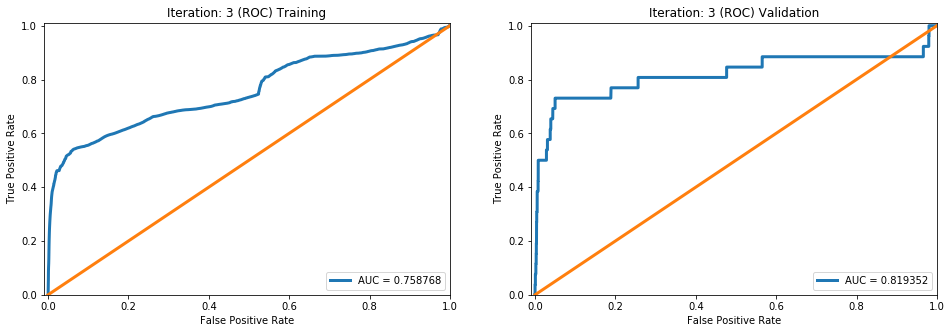

<Figure size 432x288 with 0 Axes>

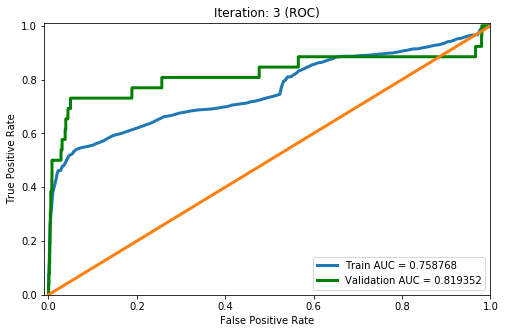

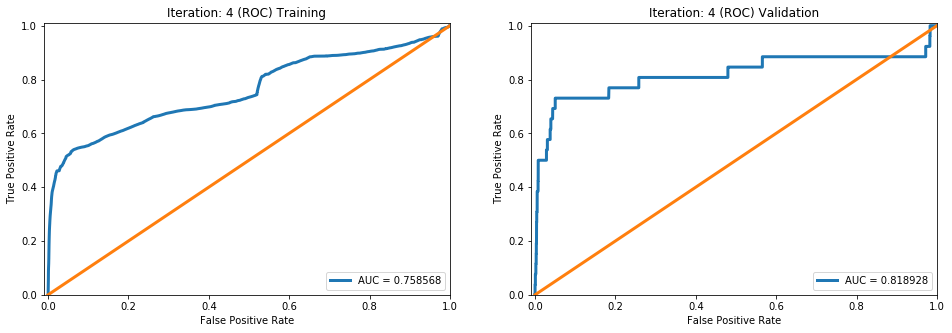

<Figure size 432x288 with 0 Axes>

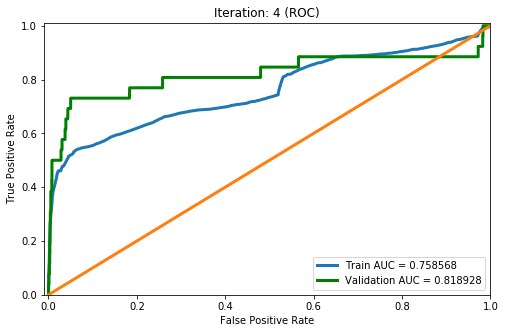

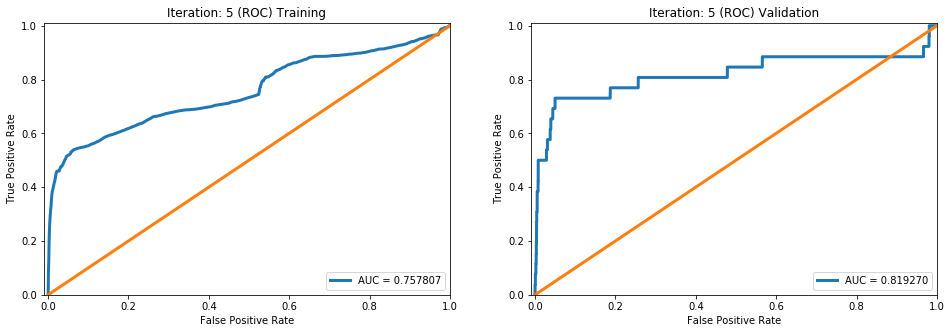

<Figure size 432x288 with 0 Axes>

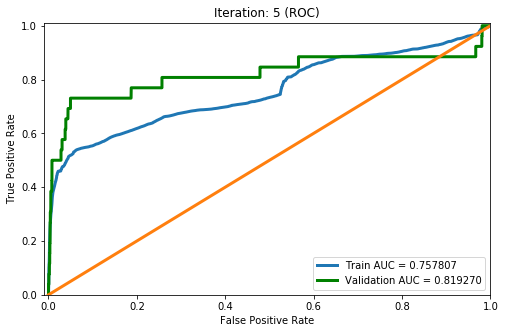

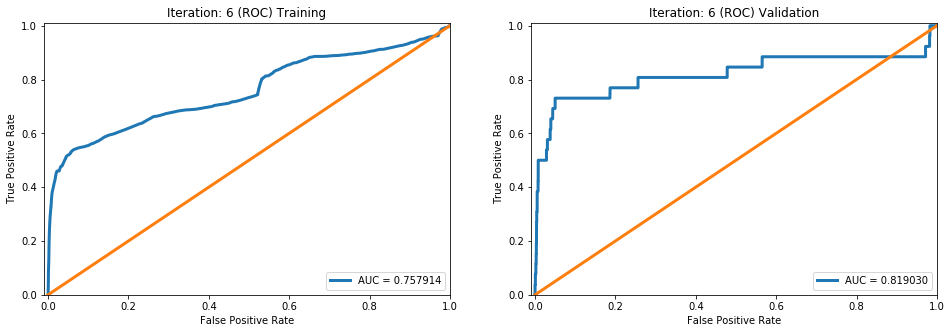

<Figure size 432x288 with 0 Axes>

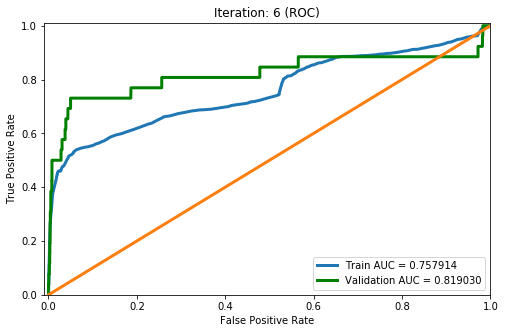

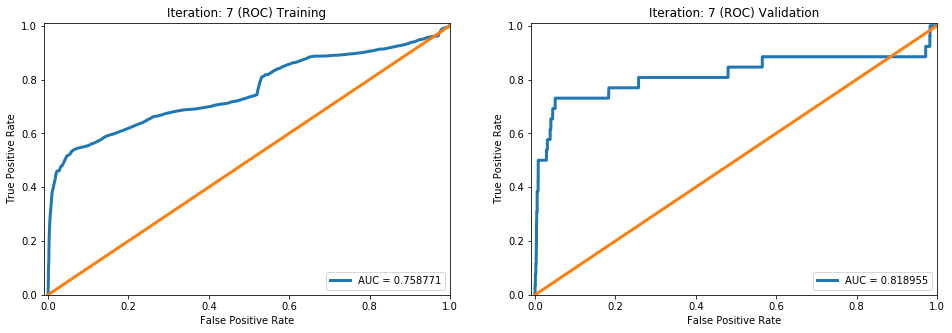

<Figure size 432x288 with 0 Axes>

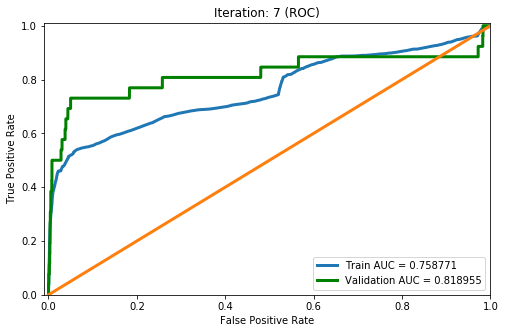

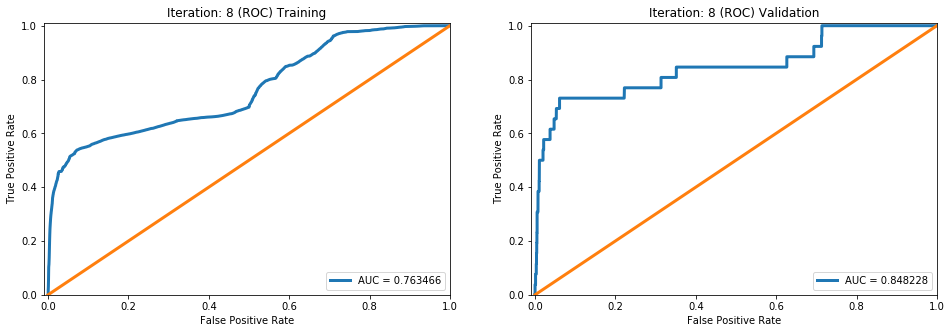

<Figure size 432x288 with 0 Axes>

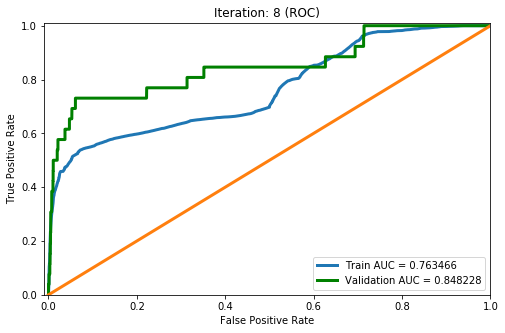

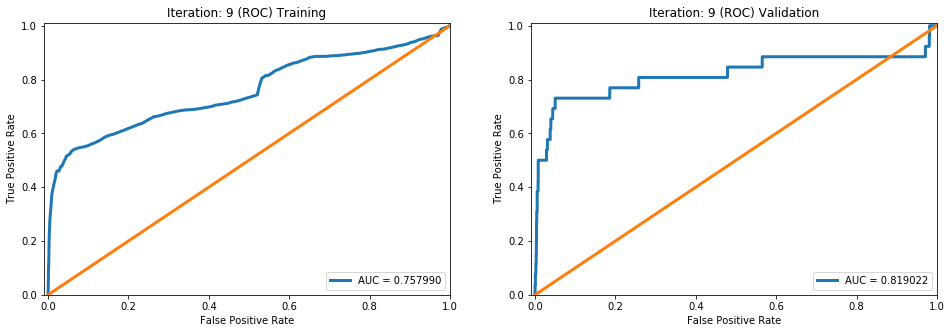

<Figure size 432x288 with 0 Axes>

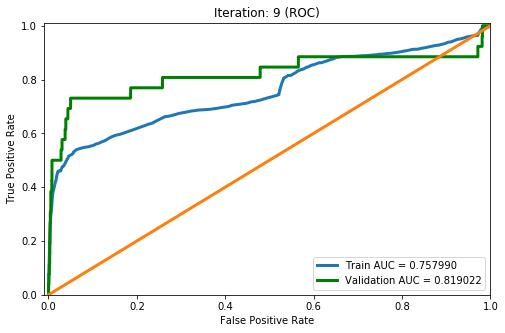

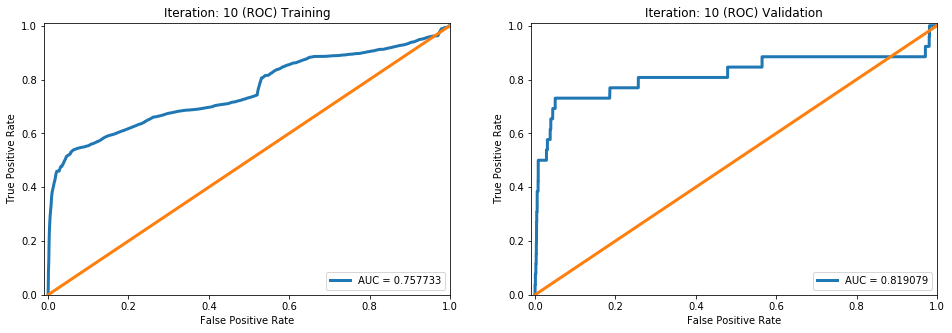

<Figure size 432x288 with 0 Axes>

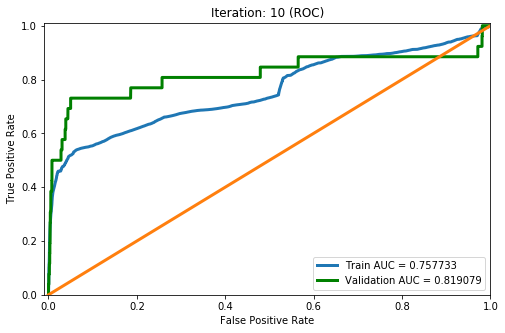

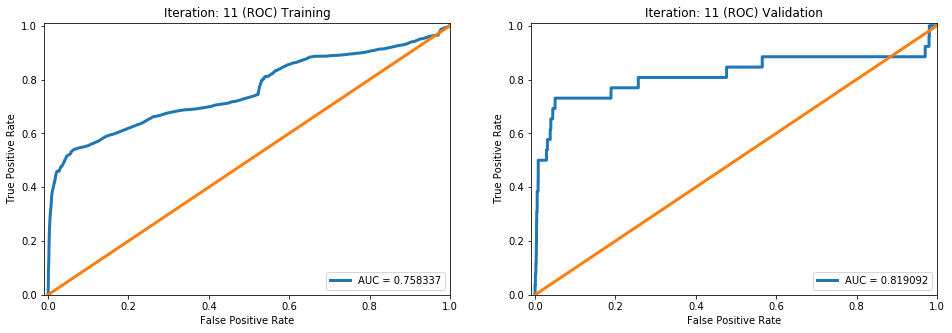

<Figure size 432x288 with 0 Axes>

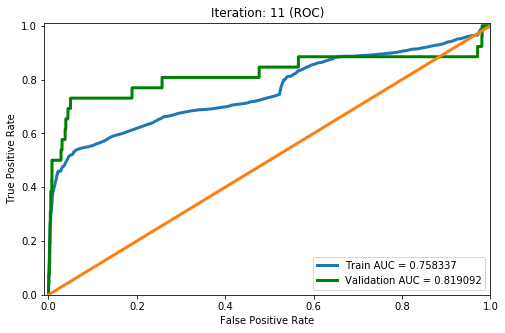

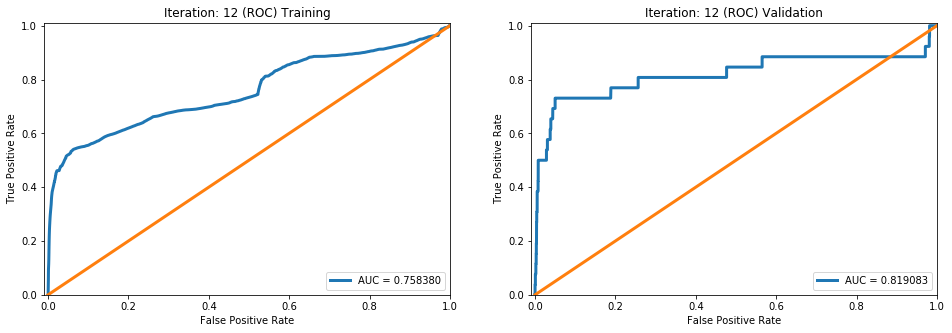

<Figure size 432x288 with 0 Axes>

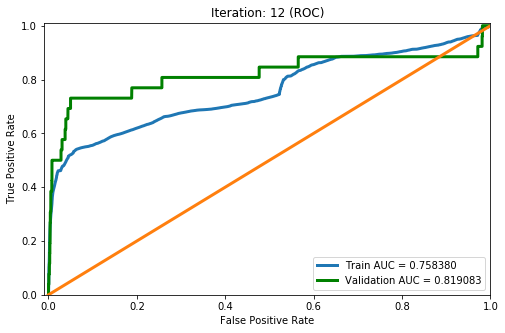

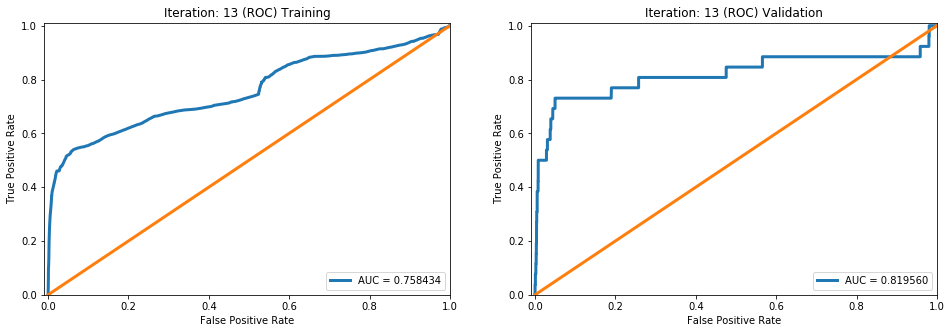

<Figure size 432x288 with 0 Axes>

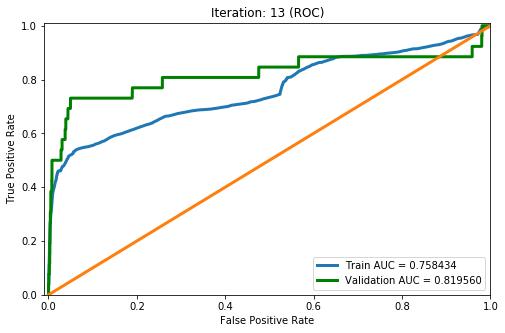

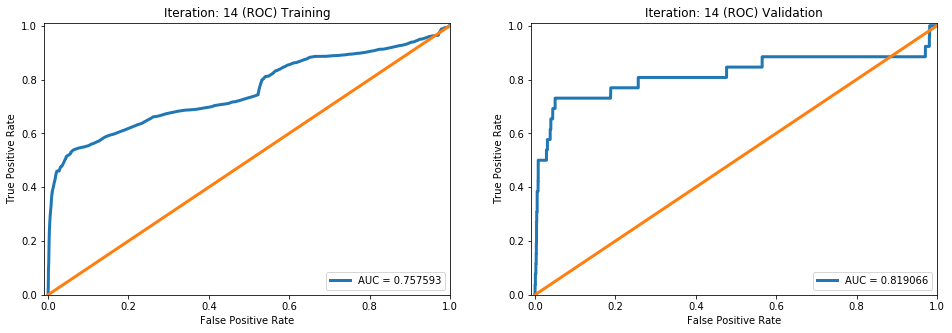

<Figure size 432x288 with 0 Axes>

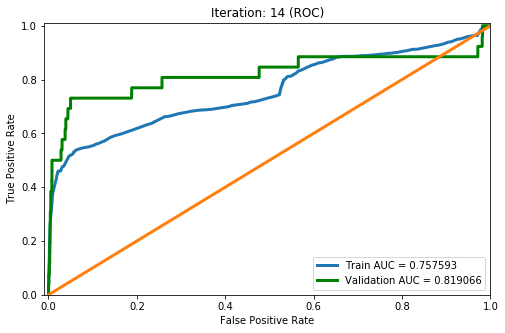

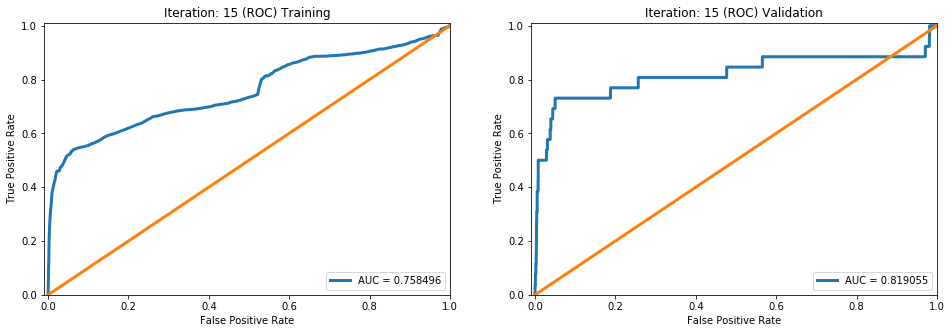

<Figure size 432x288 with 0 Axes>

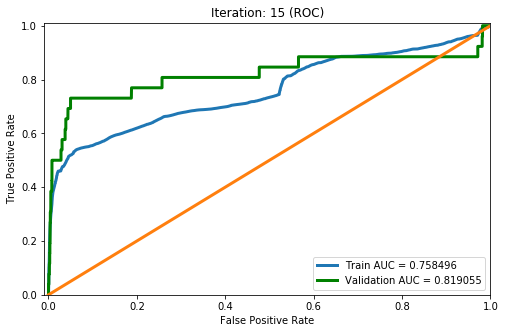

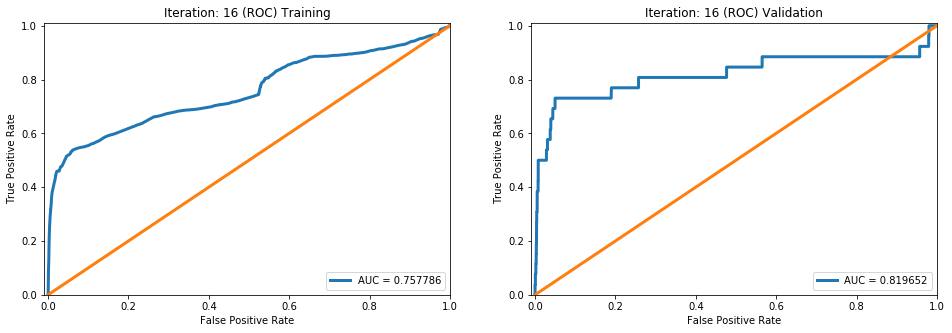

<Figure size 432x288 with 0 Axes>

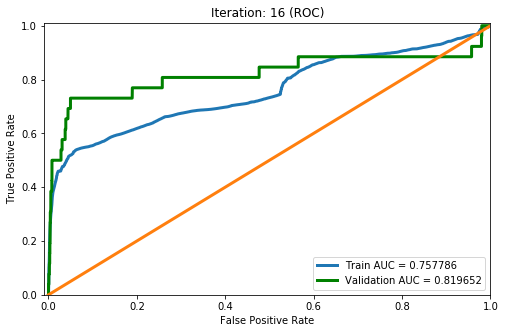

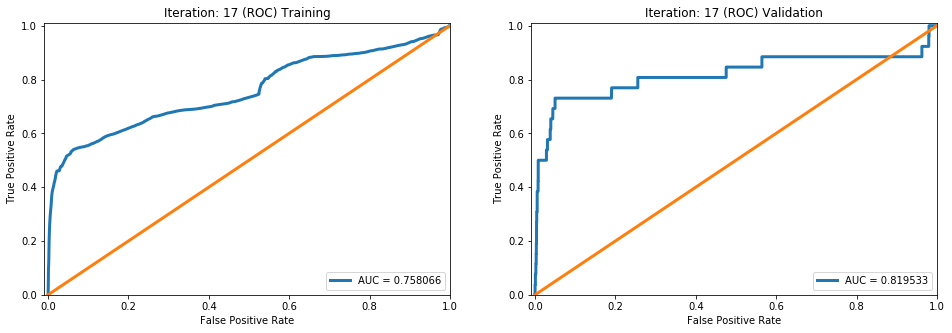

<Figure size 432x288 with 0 Axes>

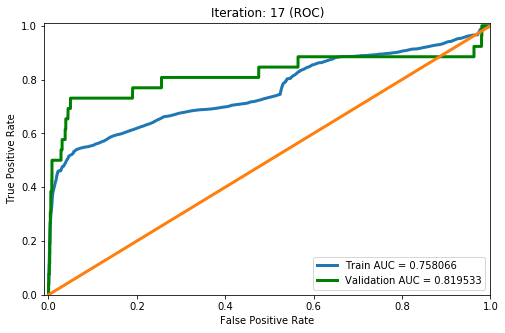

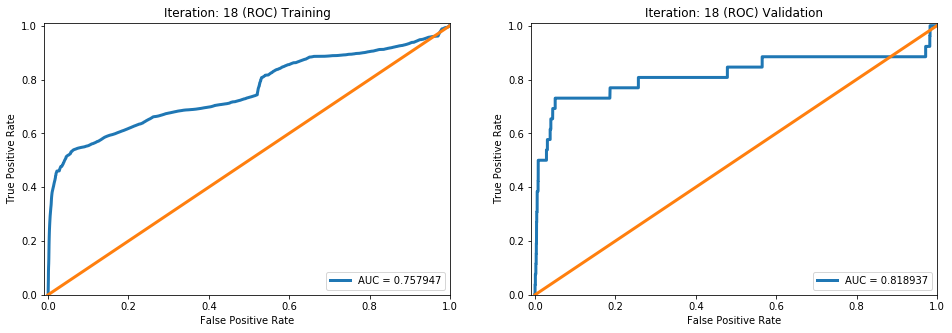

<Figure size 432x288 with 0 Axes>

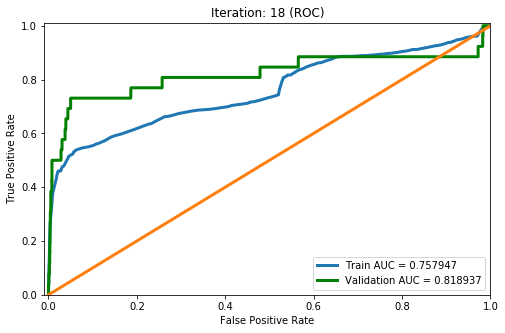

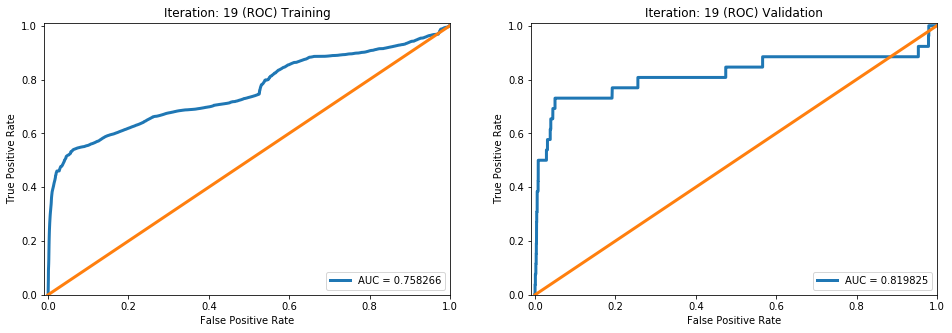

<Figure size 432x288 with 0 Axes>

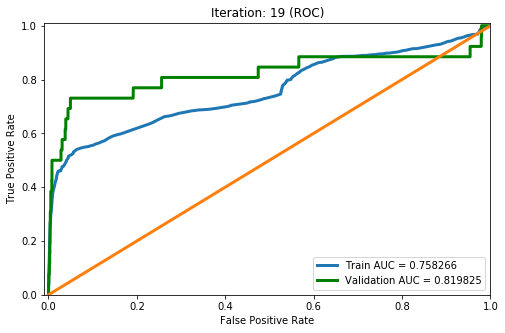

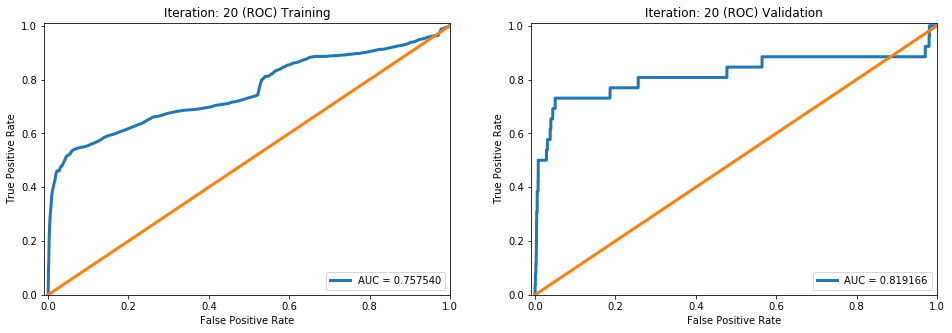

<Figure size 432x288 with 0 Axes>

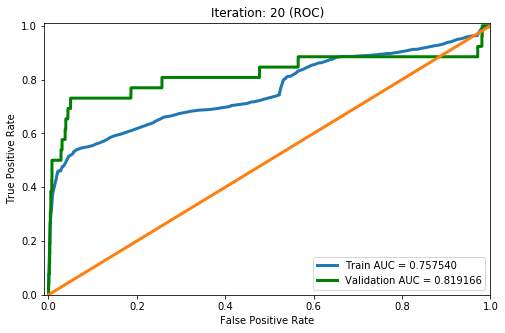

In [30]:
for it in iterations:
    false_pos_rate = training_evaluations[it]['false_pos_rate']
    true_pos_rate = training_evaluations[it]['true_pos_rate']
    roc_auc = auc(false_pos_rate, true_pos_rate)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    
    ax1.plot(false_pos_rate, true_pos_rate, linewidth=3, label='AUC = %f'% roc_auc)
    ax1.plot([0,1],[0,1], linewidth=3)

    ax1.set_xlim([-0.01, 1])
    ax1.set_ylim([0, 1.01])
    ax1.legend(loc='lower right')
    ax1.set_title('Iteration: '+ str(it) +' (ROC) Training')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')
    
    
    test_false_pos_rate = test_evaluations[it]['false_pos_rate']
    test_true_pos_rate = test_evaluations[it]['true_pos_rate']
    test_roc_auc = auc(test_false_pos_rate, test_true_pos_rate)
    
    ax2.plot(test_false_pos_rate, test_true_pos_rate, linewidth=3, label='AUC = %f'% test_roc_auc)
    ax2.plot([0,1],[0,1], linewidth=3)

    ax2.set_xlim([-0.01, 1])
    ax2.set_ylim([0, 1.01])
    ax2.legend(loc='lower right')
    ax2.set_title('Iteration: '+ str(it) +' (ROC) Validation')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_xlabel('False Positive Rate')

    plt.figure(2)
    false_pos_rate = training_evaluations[it]['false_pos_rate']
    true_pos_rate = training_evaluations[it]['true_pos_rate']
    roc_auc = auc(false_pos_rate, true_pos_rate)

    test_false_pos_rate = test_evaluations[it]['false_pos_rate']
    test_true_pos_rate = test_evaluations[it]['true_pos_rate']
    test_roc_auc = auc(test_false_pos_rate, test_true_pos_rate)

    plt.figure(figsize=(8, 5))
    plt.plot(false_pos_rate, true_pos_rate, linewidth=3, label='Train AUC = %f'% roc_auc)
    plt.plot(test_false_pos_rate, test_true_pos_rate, linewidth=3, label='Validation AUC = %f'% test_roc_auc, color='g')
    plt.plot([0,1],[0,1], linewidth=3)
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])

    plt.legend(loc='lower right')
    plt.title('Iteration: '+ str(it) +' (ROC)')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

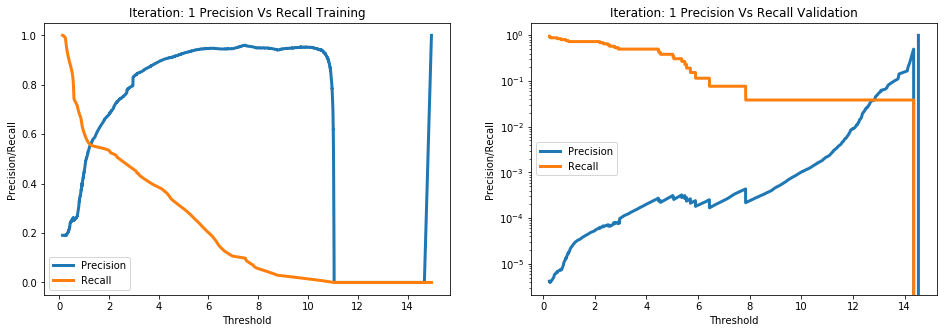

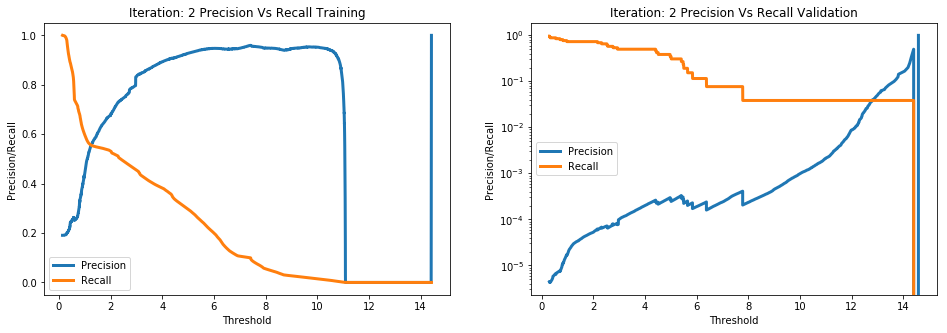

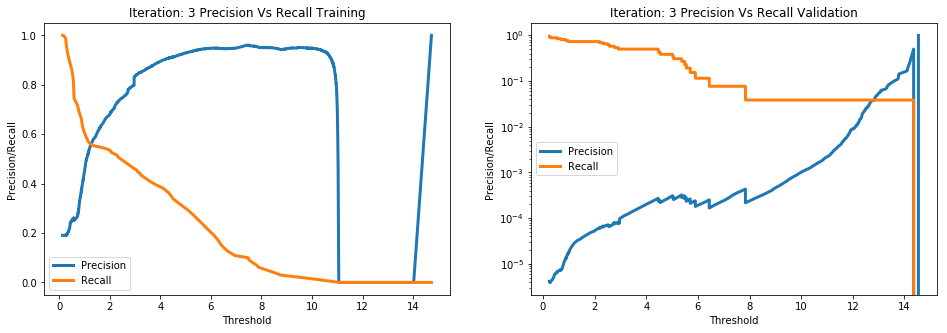

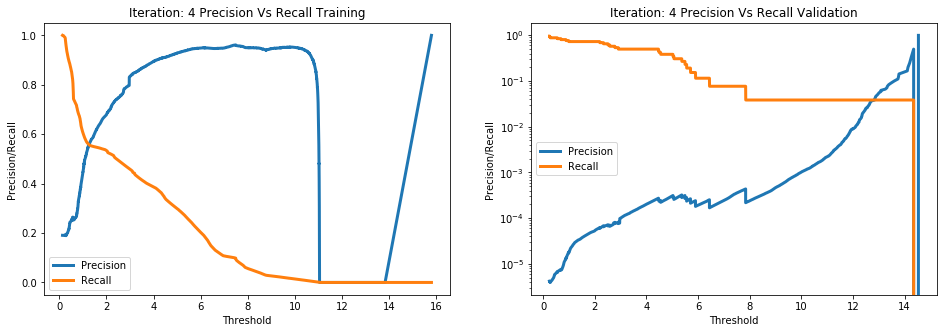

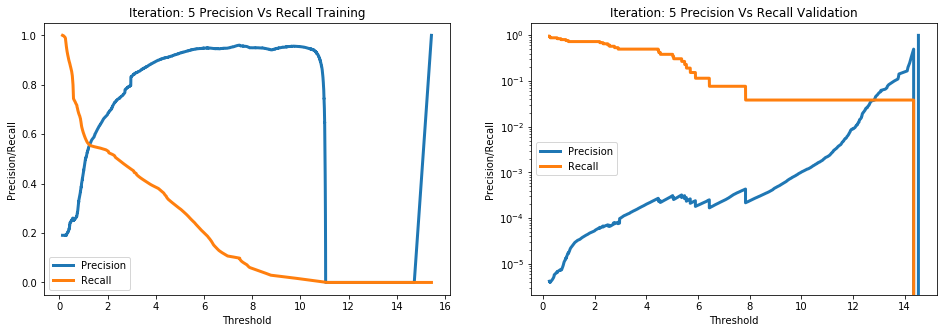

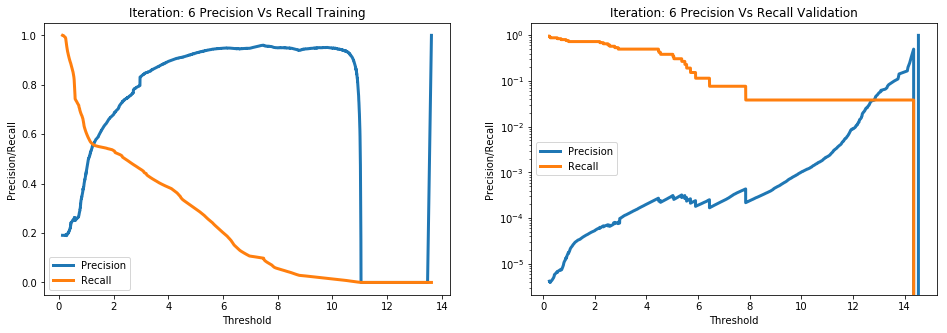

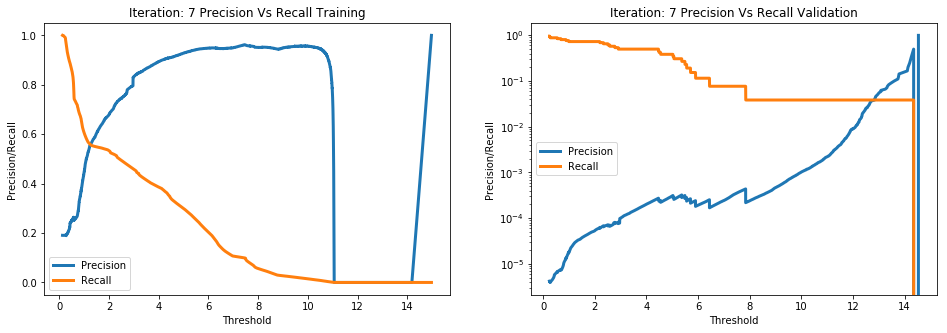

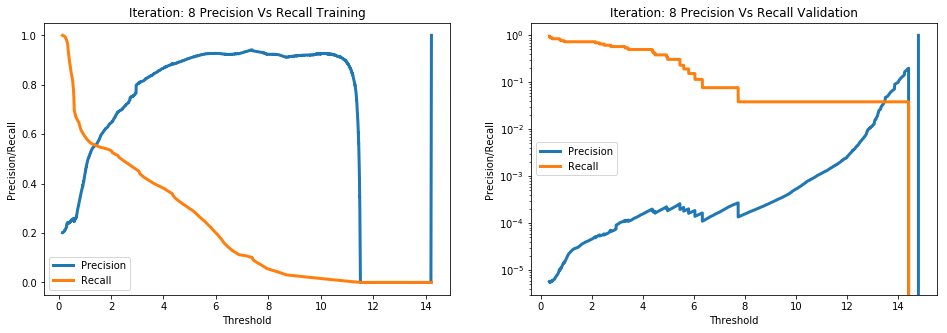

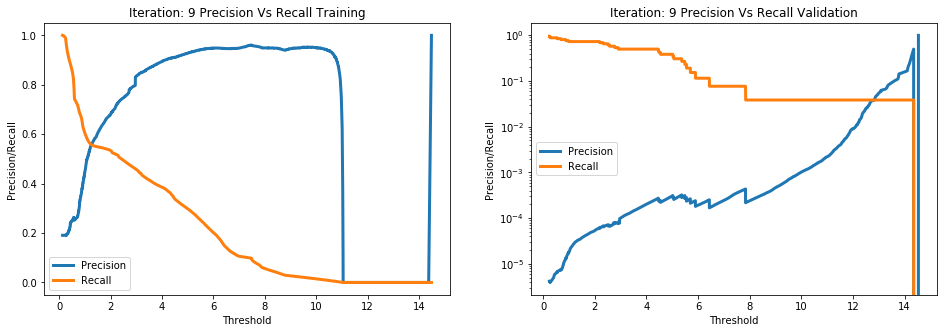

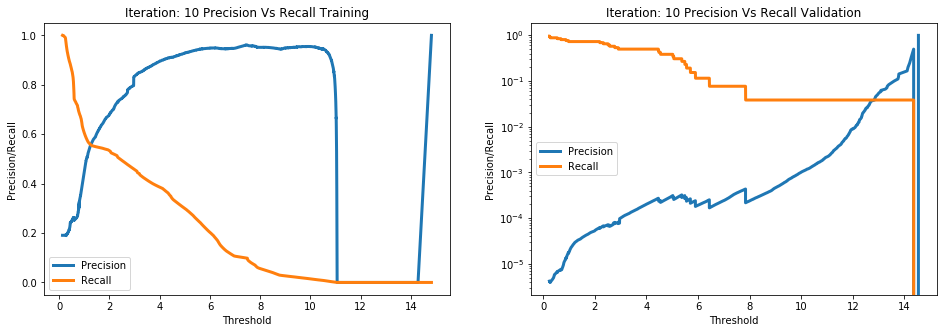

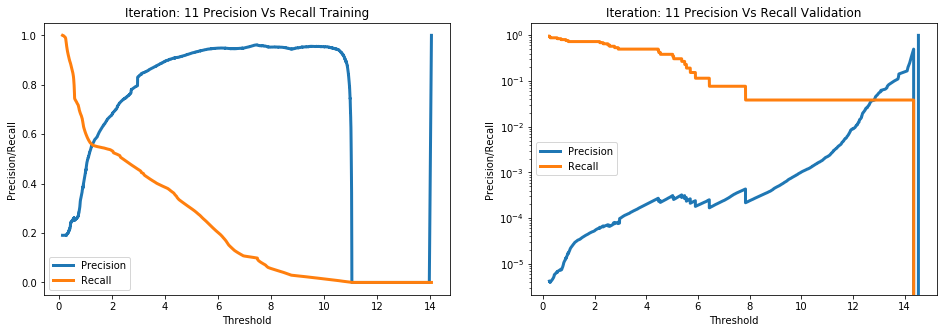

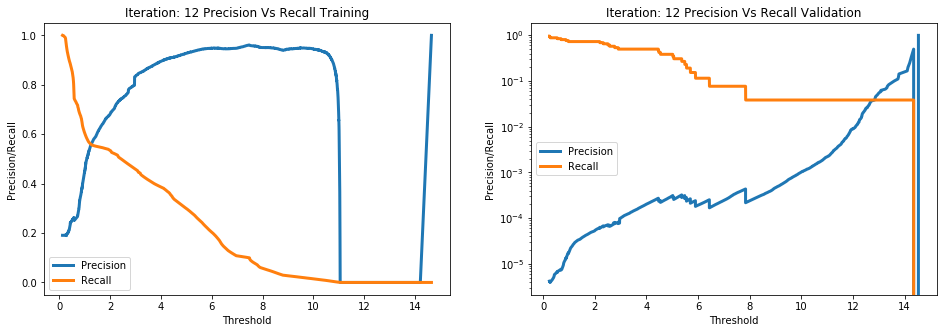

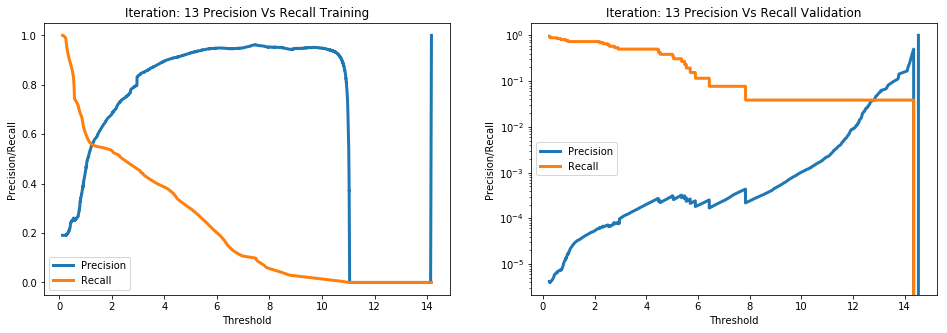

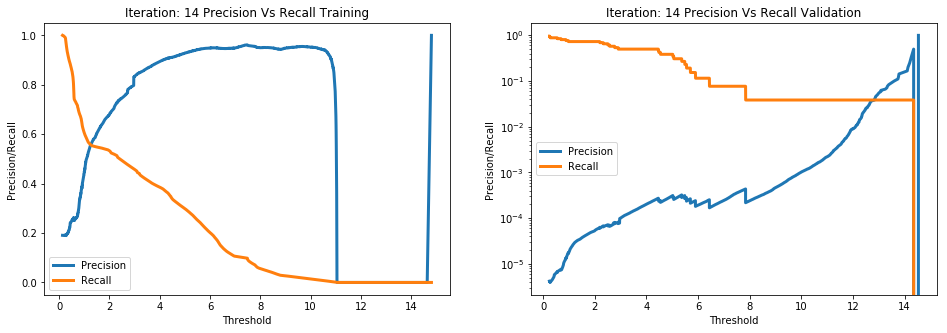

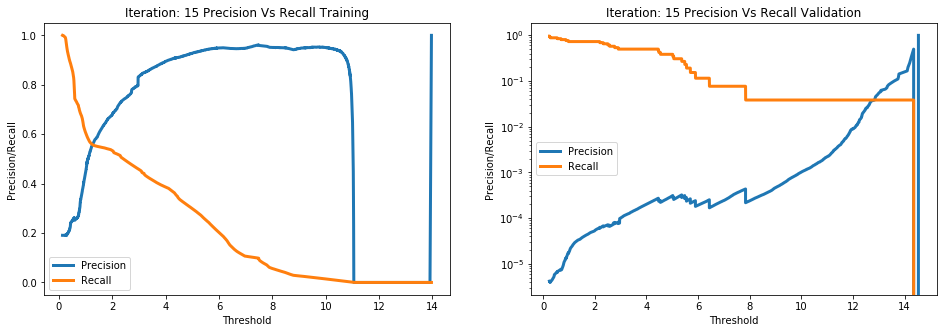

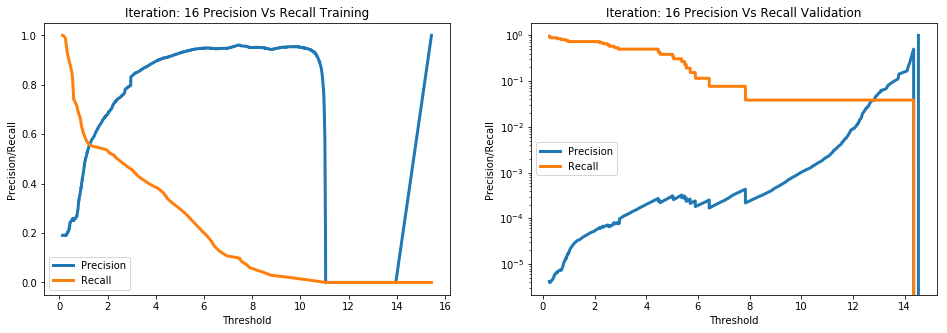

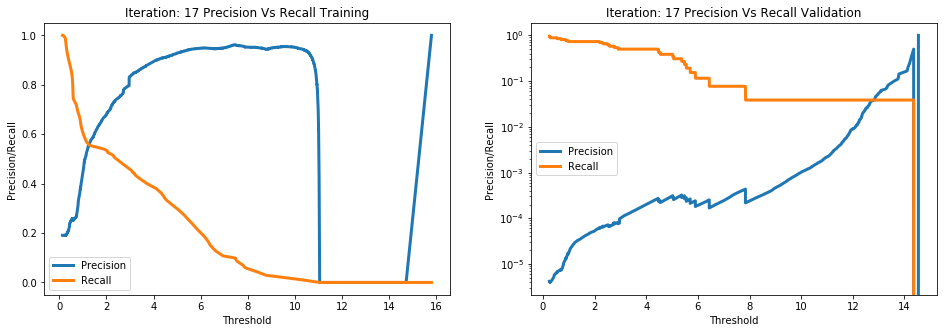

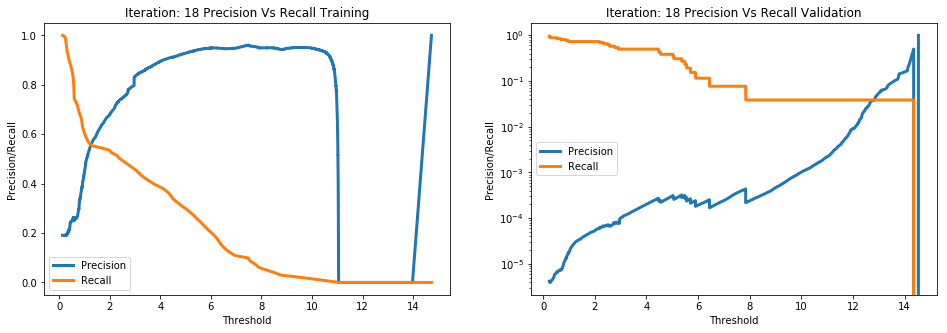

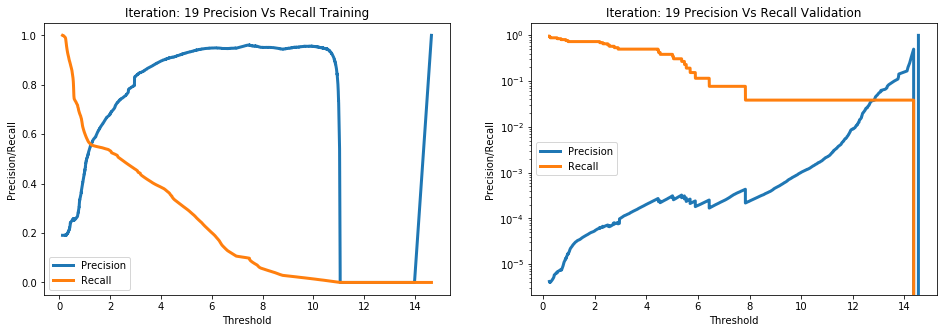

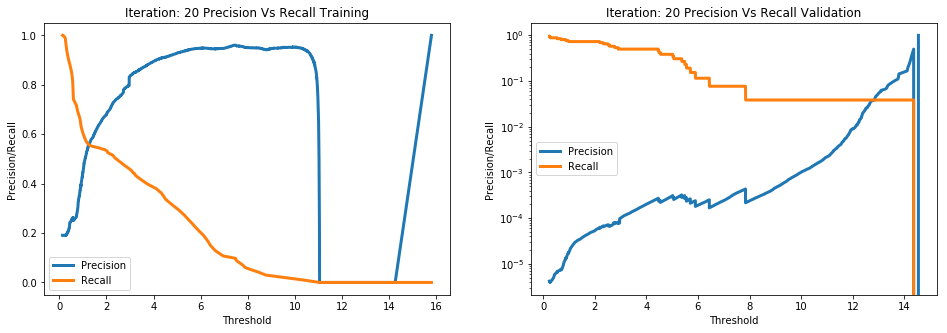

In [31]:
for it in iterations:
    precision_rt = training_evaluations[it]['precision_rt']
    recall_rt = training_evaluations[it]['recall_rt']
    threshold_rate = training_evaluations[it]['threshold_rt']
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    
    ax1.plot(threshold_rate, precision_rt[1:], label="Precision",linewidth=3)
    ax1.plot(threshold_rate, recall_rt[1:], label="Recall",linewidth=3)
#     ax1.set_yscale('log')
    ax1.legend()
    ax1.set_title('Iteration: '+ str(it) +' Precision Vs Recall Training')
    ax1.set_ylabel('Precision/Recall')
    ax1.set_xlabel('Threshold')
    
    
    precision_rt = test_evaluations[it]['precision_rt']
    recall_rt = test_evaluations[it]['recall_rt']
    threshold_rate = test_evaluations[it]['threshold_rt']
    ax2.plot(threshold_rate, precision_rt[1:], label="Precision",linewidth=3)
    ax2.plot(threshold_rate, recall_rt[1:], label="Recall",linewidth=3)
    ax2.legend()
    ax2.set_yscale('log')
    ax2.set_title('Iteration: '+ str(it) +' Precision Vs Recall Validation')
    ax2.set_ylabel('Precision/Recall')
    ax2.set_xlabel('Threshold')

# Confusion Matrix

In [32]:
def conf_matrix_percent(conf_matrix_train, conf_matrix_test, iteration):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    LABELS = ["Normal", "Fraud"]
    #Confusion Matrix Visual)
    conf_matrix_train = conf_matrix_train.astype('float') / (conf_matrix_train.sum(axis=1)[:, np.newaxis])
    sns.heatmap(conf_matrix_train, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt=".0%", annot_kws={"size": 12}, ax=ax1)
    ax1.set_title("Training Iteration: "+str(iteration)+" Confusion matrix")
    ax1.set_ylabel('True class')
    ax1.set_xlabel('Predicted class')
    
    conf_matrix_test = conf_matrix_test.astype('float') / (conf_matrix_test.sum(axis=1)[:, np.newaxis])
    sns.heatmap(conf_matrix_test, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt=".0%", annot_kws={"size": 12}, ax=ax2)
    ax2.set_title("Test Iteration: "+str(iteration)+" Confusion matrix")
    ax2.set_ylabel('True class')
    ax2.set_xlabel('Predicted class')

In [33]:
def conf_matrix_normal(conf_matrix_train, conf_matrix_test, iteration):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    LABELS = ["Normal", "Fraud"]
    #Confusion Matrix Visual)
#     conf_matrix_train = conf_matrix_train.astype('float') / (conf_matrix_train.sum(axis=1)[:, np.newaxis])
    sns.heatmap(conf_matrix_train, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", ax=ax1);
    ax1.set_title("Training Iteration: "+str(iteration)+" Confusion matrix")
    ax1.set_ylabel('True class')
    ax1.set_xlabel('Predicted class')
    
#     conf_matrix_test = conf_matrix_test.astype('float') / (conf_matrix_test.sum(axis=1)[:, np.newaxis])
    sns.heatmap(conf_matrix_test, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", ax=ax2);
    ax2.set_title("Test Iteration: "+str(iteration)+" Confusion matrix")
    ax2.set_ylabel('True class')
    ax2.set_xlabel('Predicted class')

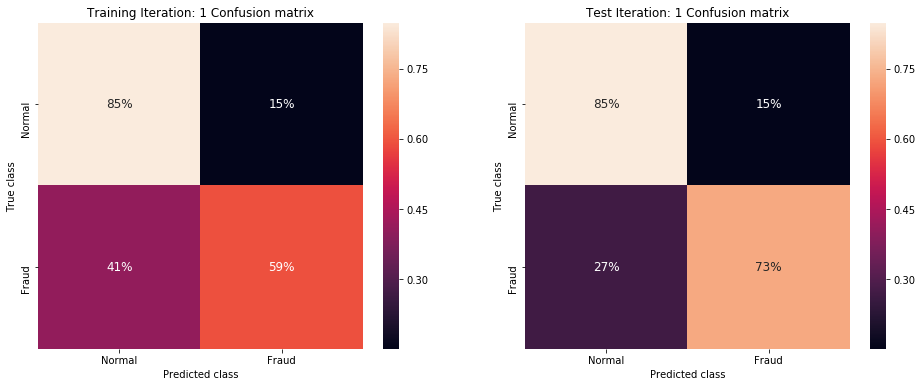

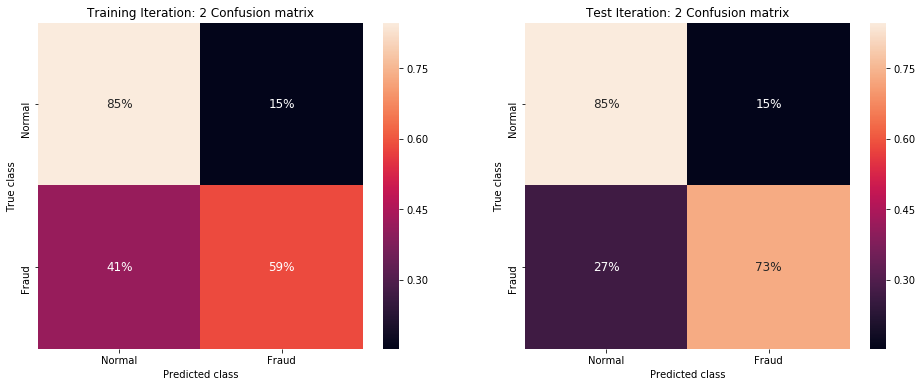

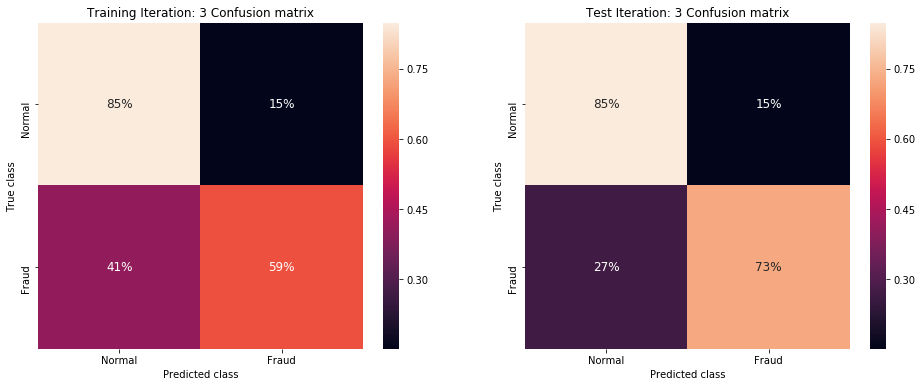

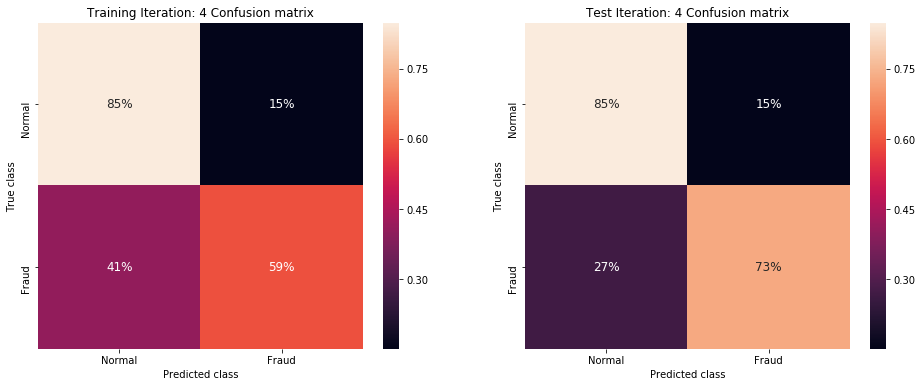

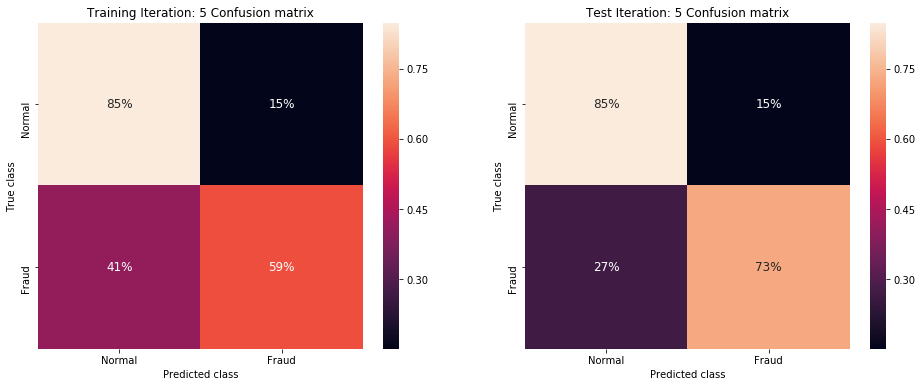

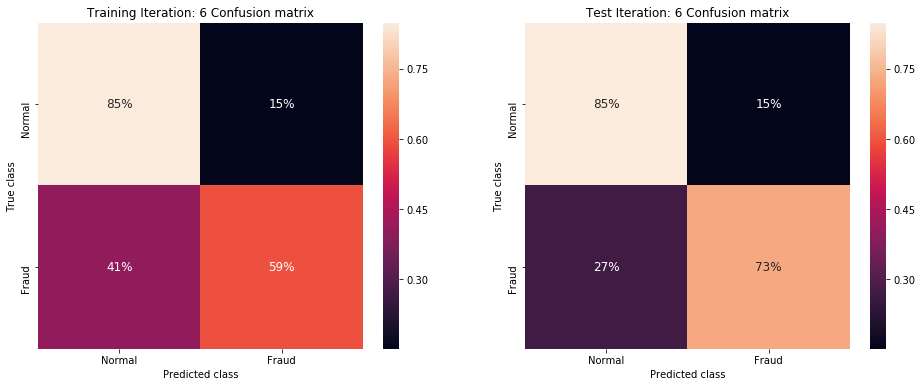

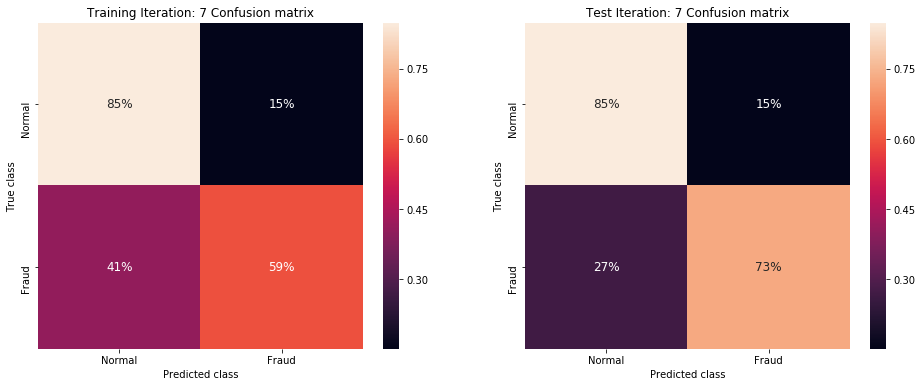

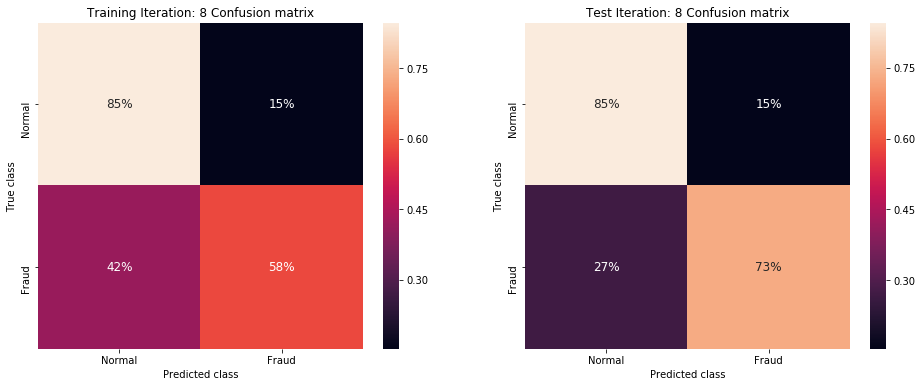

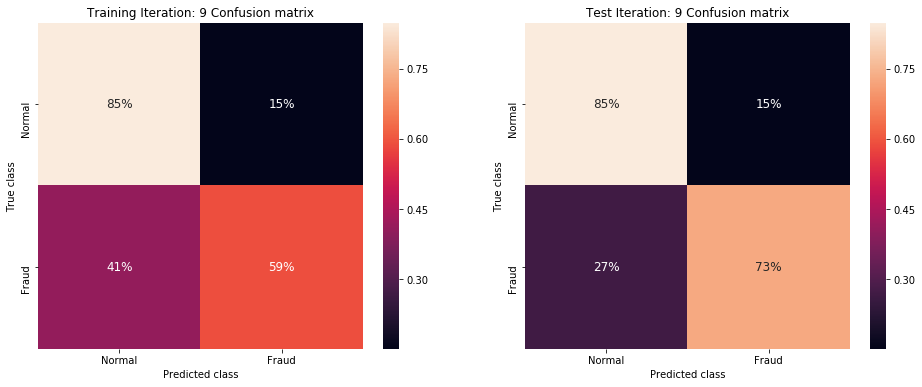

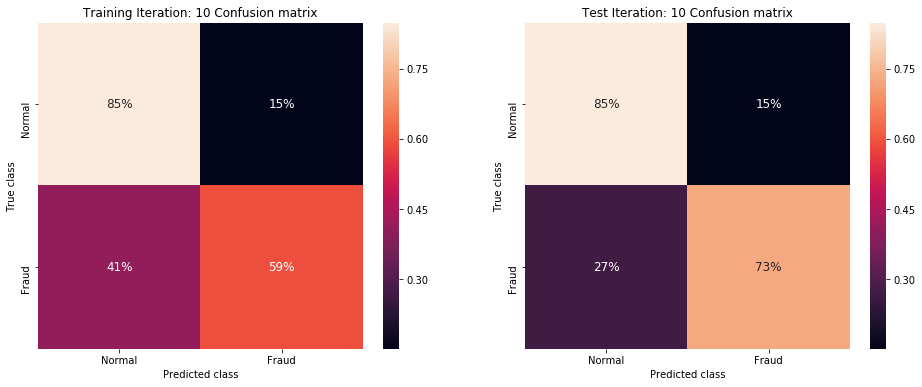

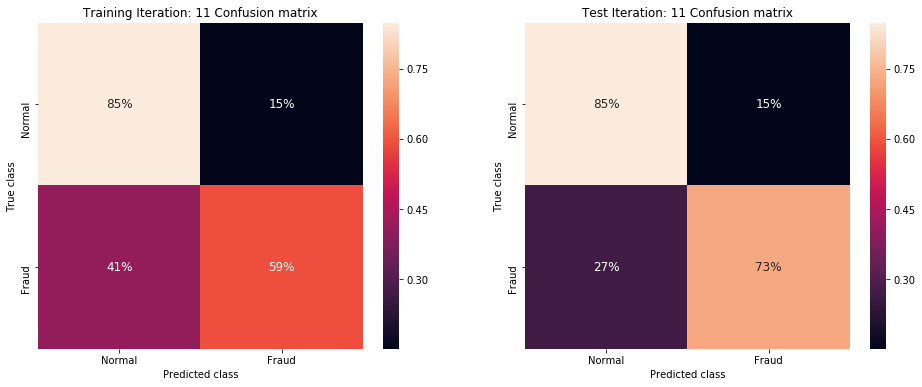

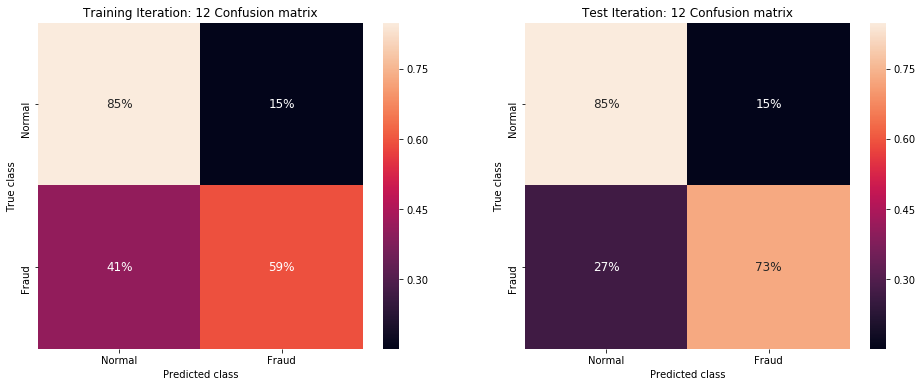

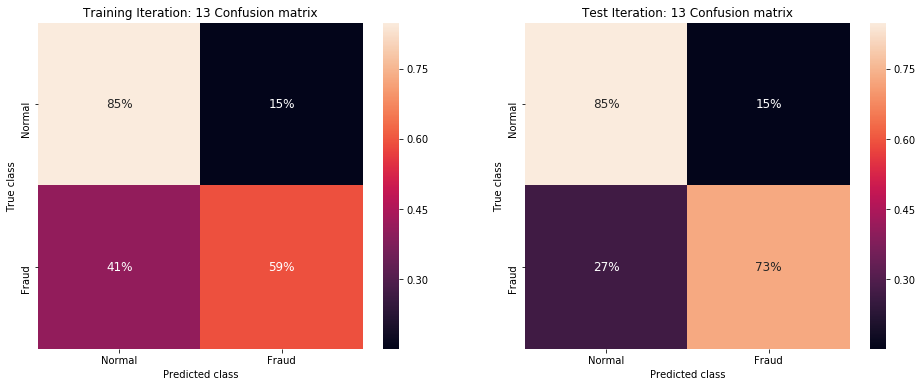

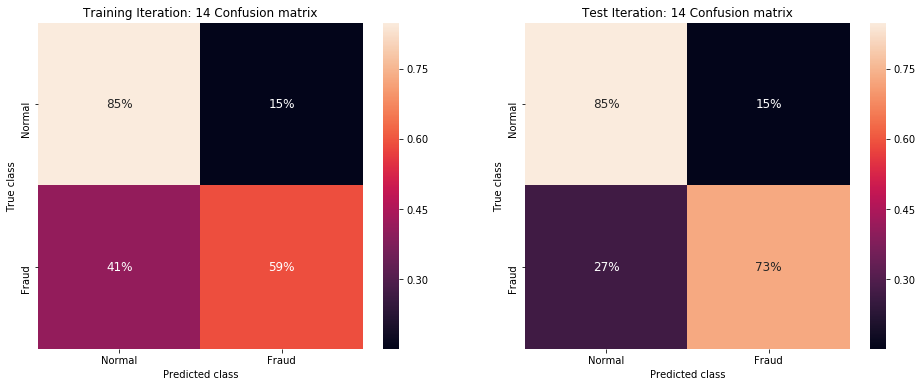

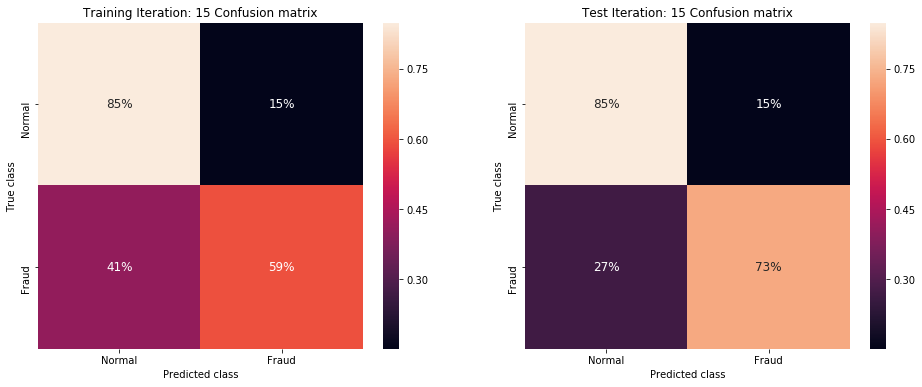

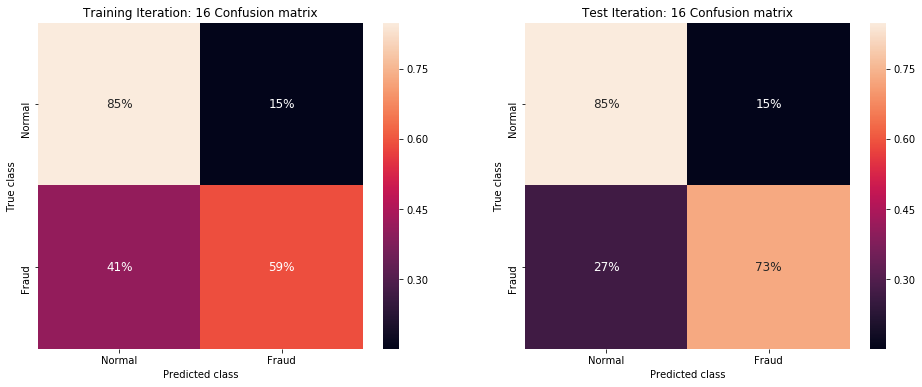

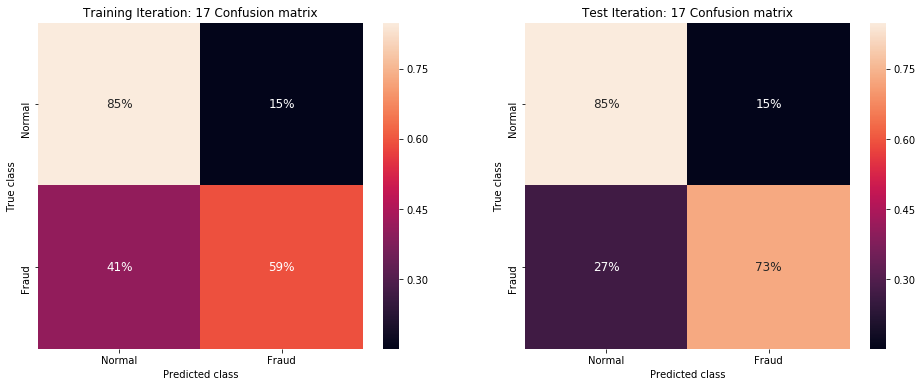

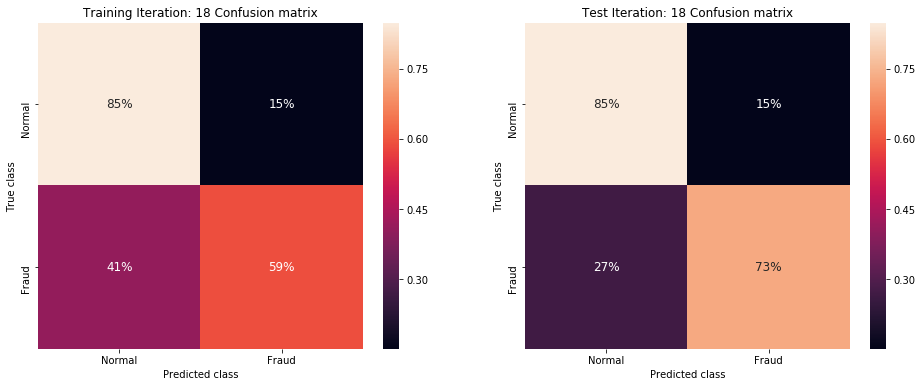

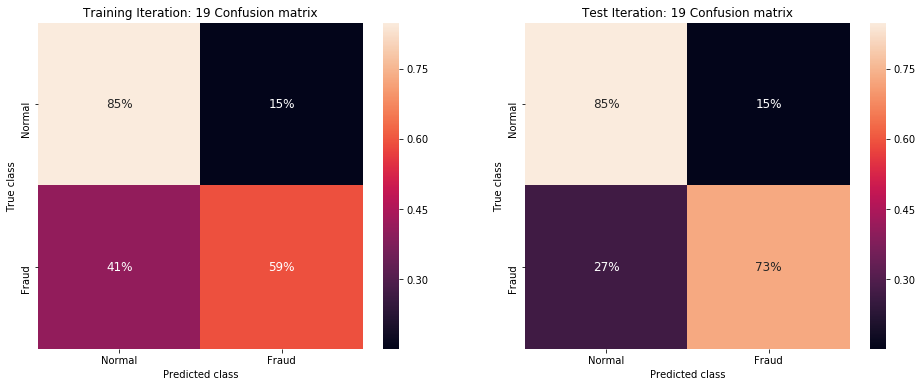

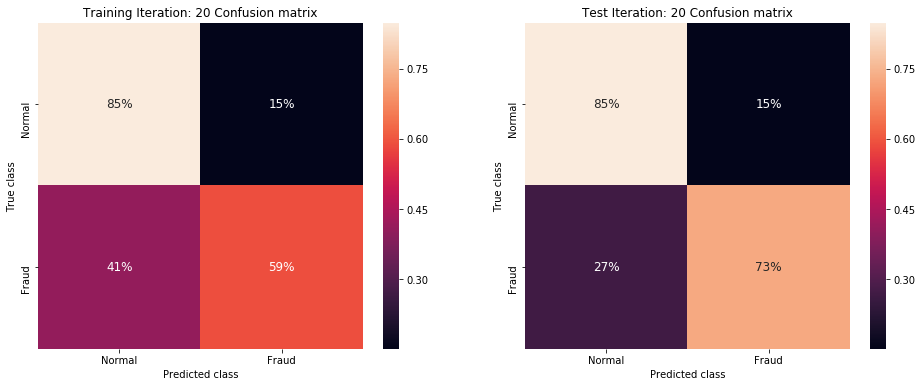

In [34]:
for it in iterations:
    cnf_mtx_train = training_evaluations[it]['conf_matrix']
    cnf_mtx_test = test_evaluations[it]['conf_matrix']
    conf_matrix_percent(cnf_mtx_train, cnf_mtx_test, it)

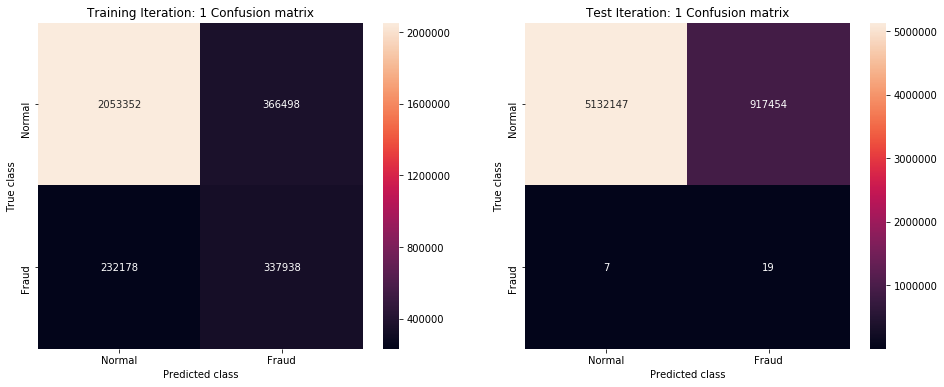

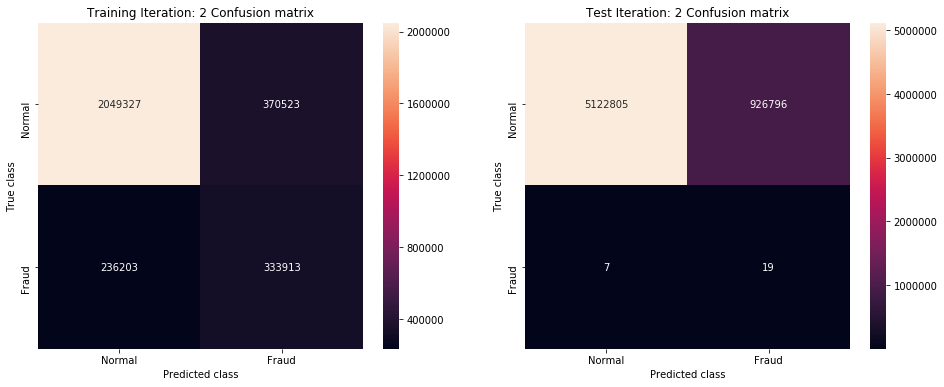

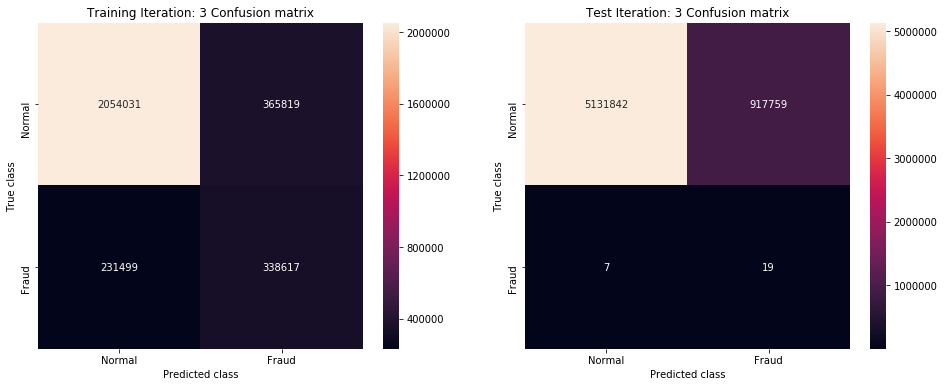

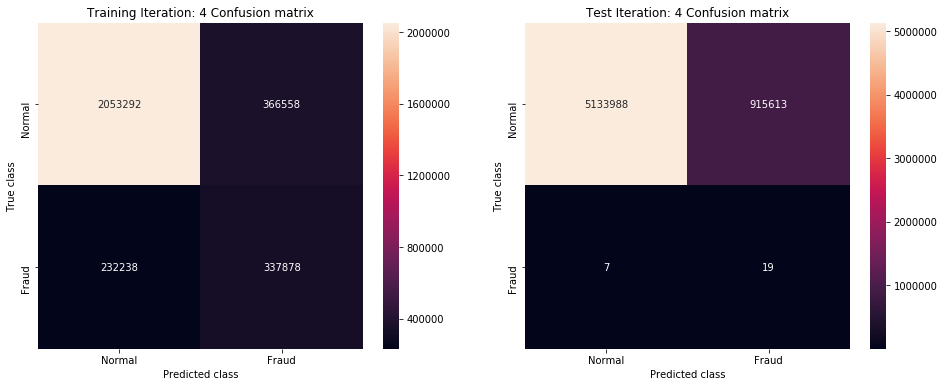

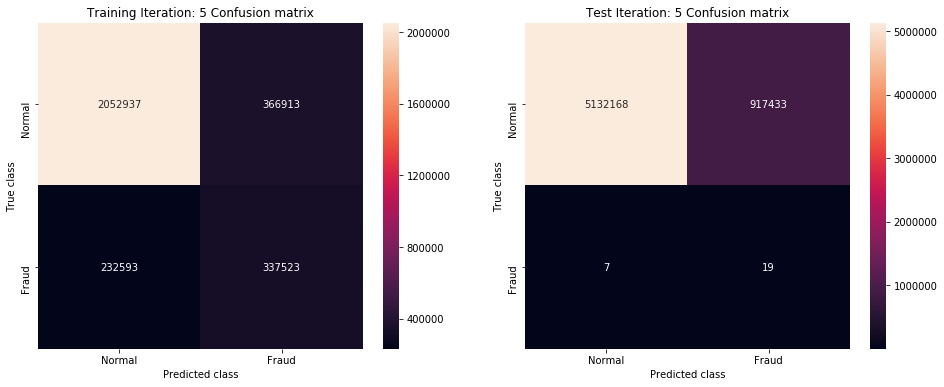

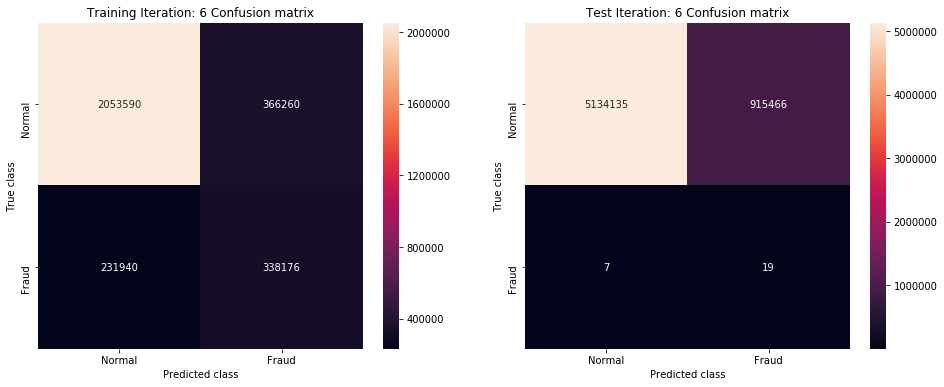

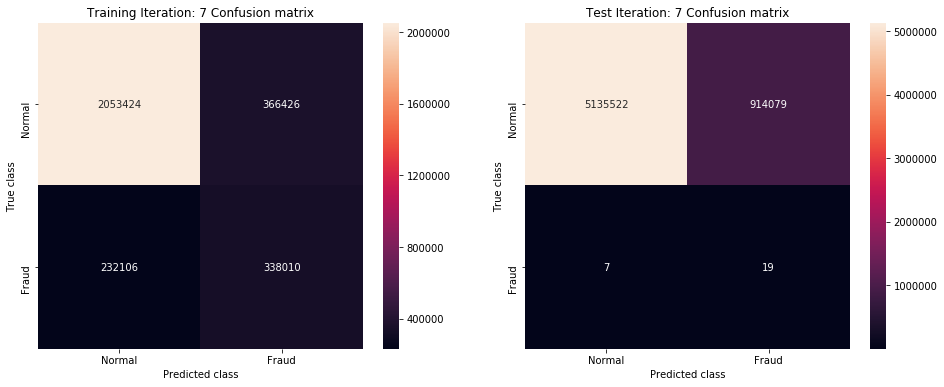

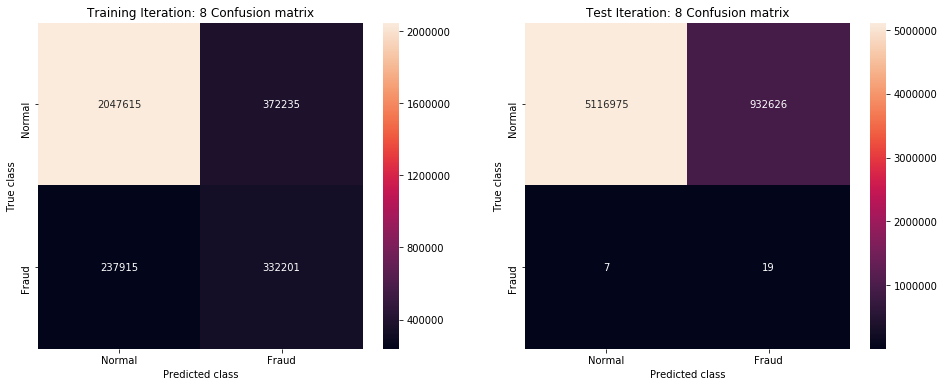

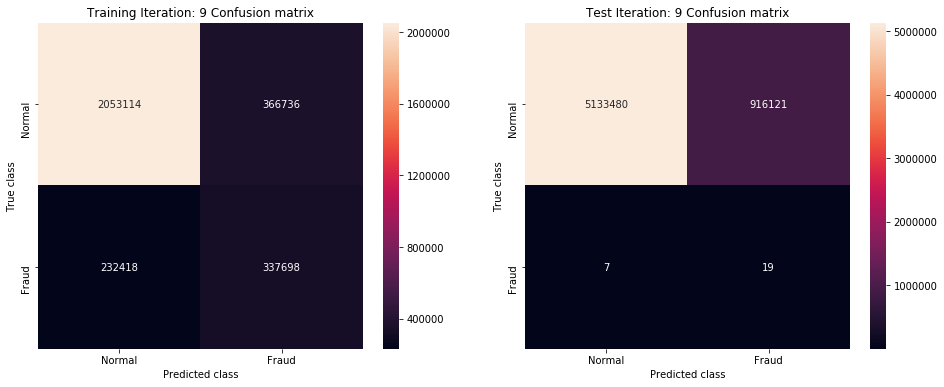

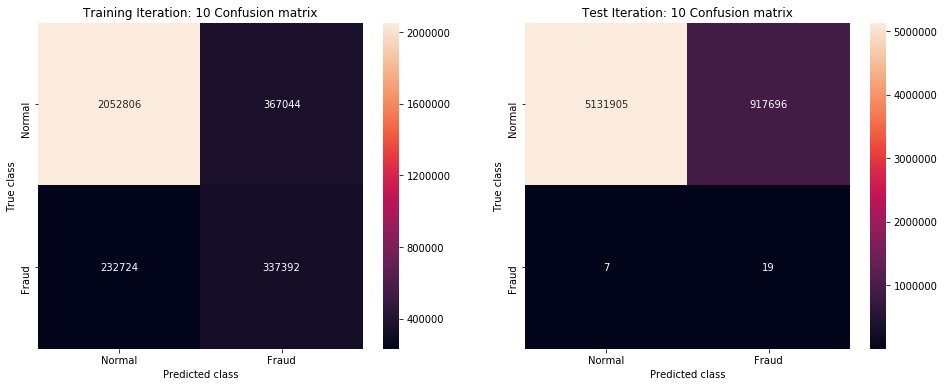

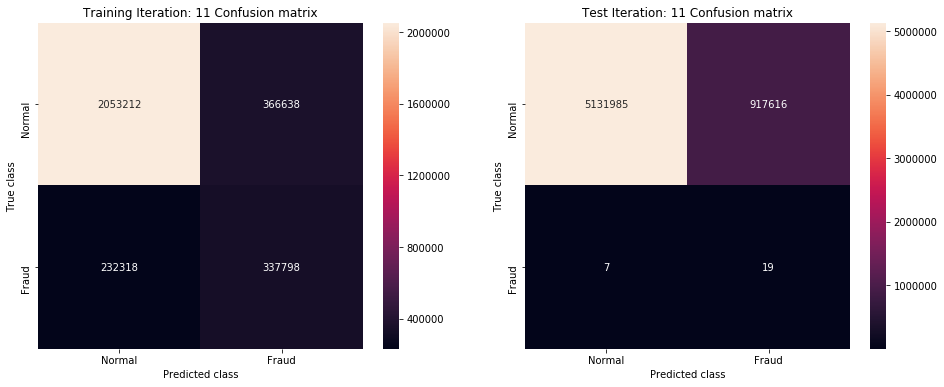

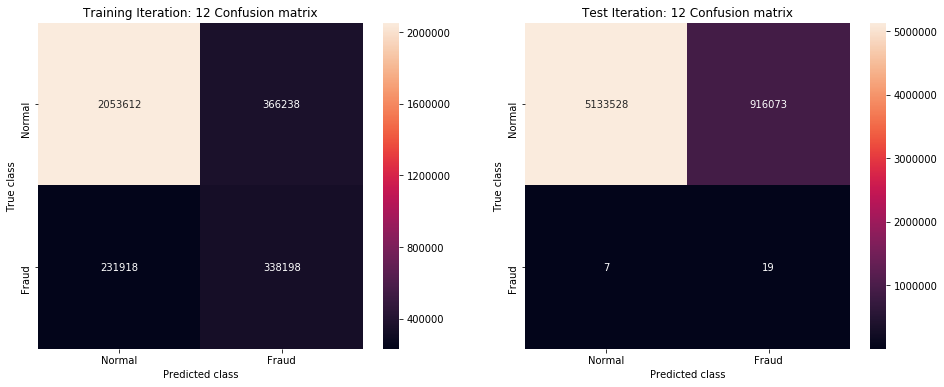

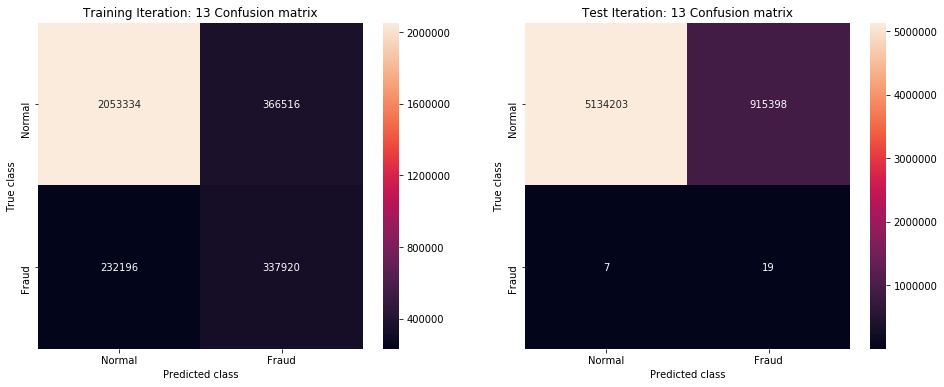

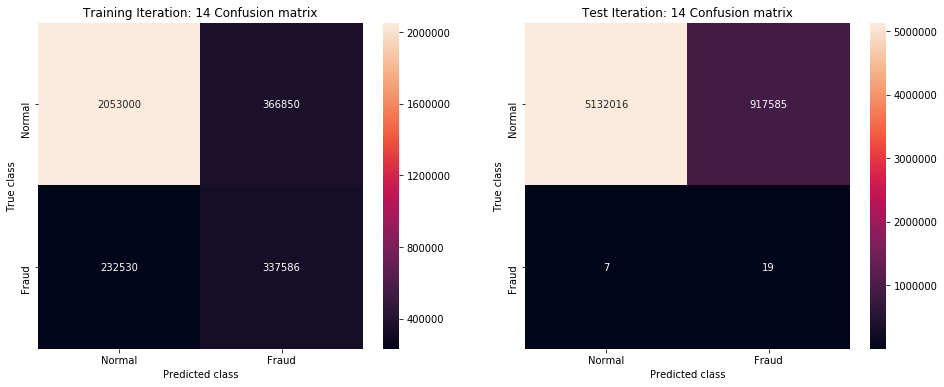

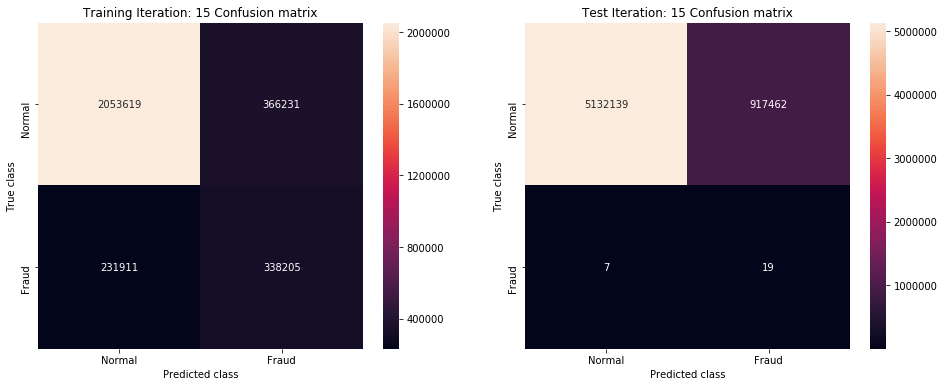

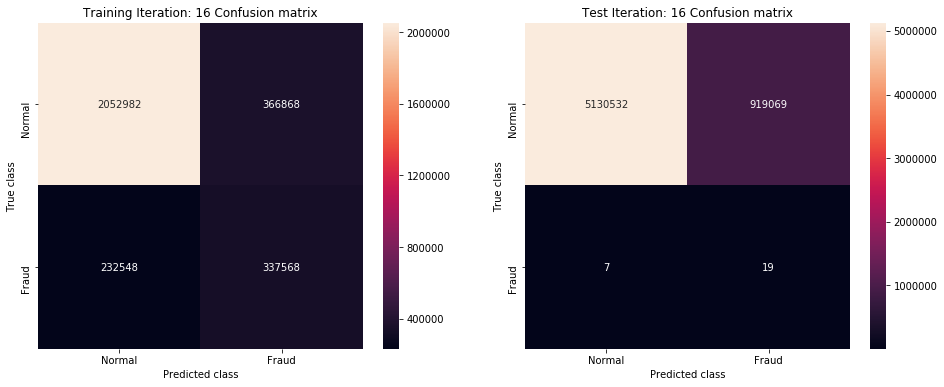

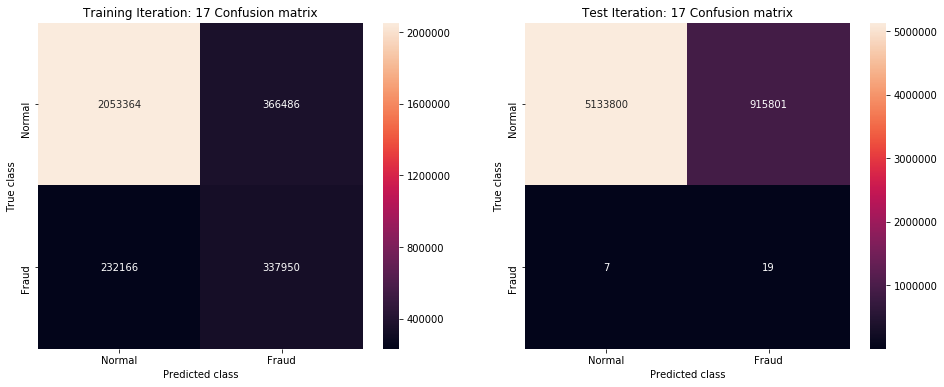

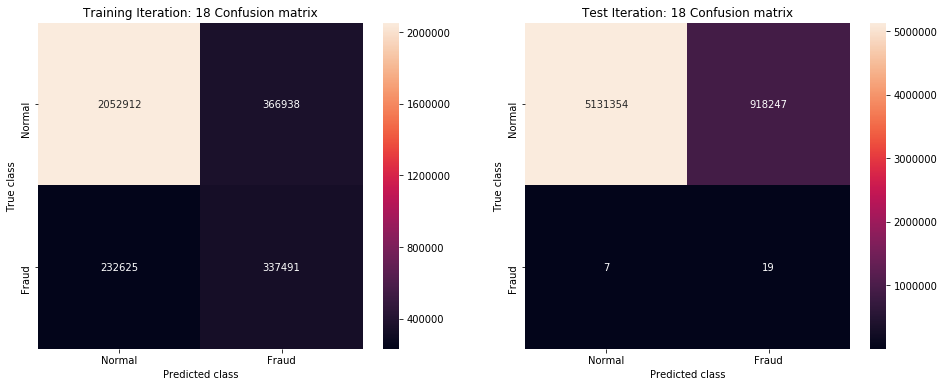

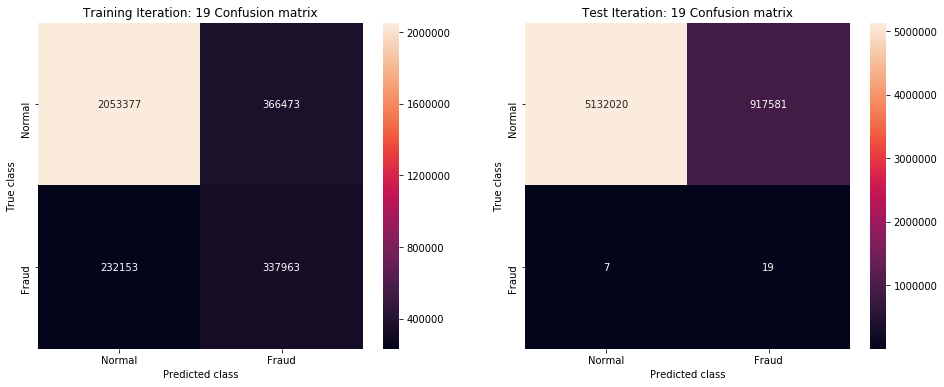

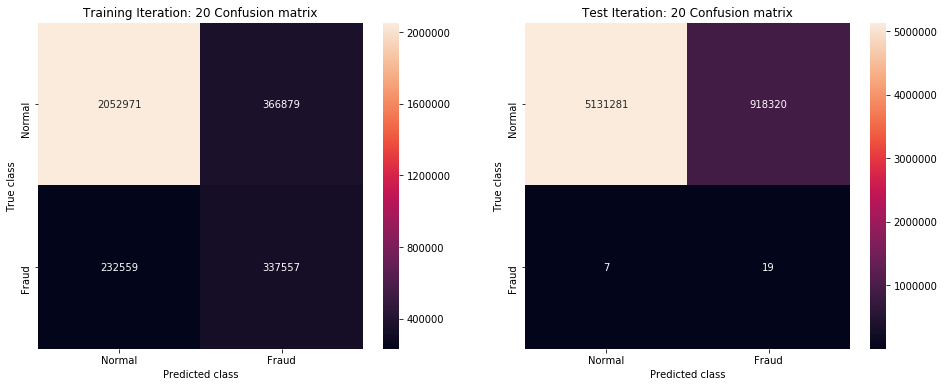

In [35]:
for it in iterations:
    cnf_mtx_train = training_evaluations[it]['conf_matrix']
    cnf_mtx_test = test_evaluations[it]['conf_matrix']
    conf_matrix_normal(cnf_mtx_train, cnf_mtx_test, it)

# Parameter Tuning

In [19]:
from hyperopt import Trials, STATUS_OK, fmin, tpe, hp

space={
'n_clusters': hp.uniform('n_clusters', 3, 14),
'outliers_fraction': hp.uniform('outliers_fraction', 0.05, 0.25),
'alpha': hp.uniform('alpha', 0.1, 0.9),
'beta': hp.uniform('beta', 1, 15)
}

random_state = 42
training_sample_size = int(len(original_ytrain) / 10)
sample_Xtrain, sample_ytrain = get_training_sample(training_sample_size)
print('Training With:')
print(pd.value_counts(sample_ytrain))


def hyper_parm_opt(space):
    start = time.time()
    n_clusters = int(space['n_clusters'])
    outliers_fraction = space['outliers_fraction']
    alpha = space['alpha']
    beta = space['beta']
    print(n_clusters)
    X_train, y_train = oversample_minority_class(sample_Xtrain, sample_ytrain, outliers_fraction)
    clf = CBLOF(n_clusters=n_clusters, contamination=outliers_fraction, clustering_estimator=None, alpha=alpha, beta=beta, use_weights=False, check_estimator=False, random_state=random_state, n_jobs=-1)
    clf.fit(X_train)
    y_train_pred = clf.labels_
    score = f1_score(y_train, y_train_pred, average="macro")
    val = 1 - score
    end = time.time()
    print('time: ' + str(round(end - start, 4)) + ' seconds')
    print('params: '+ str(space))
    print('val: ' + str(val))
    print('')
    return {'loss': val, 'status': STATUS_OK}


trials = Trials()
best = fmin(fn=hyper_parm_opt, space=space, algo=tpe.suggest, max_evals=500, trials=trials)


print('\n\n\nbest: {}'.format(best))

Training With:
0    2419850
1         82
dtype: int64
13
time: 70.1596 seconds
params: {'alpha': 0.2947896387374696, 'beta': 12.452248014359904, 'n_clusters': 13.727959967302366, 'outliers_fraction': 0.11724941253401713}
val: 0.36934900587983666

6
time: 34.6023 seconds
params: {'alpha': 0.11548330251360195, 'beta': 1.9704916909872645, 'n_clusters': 6.563565650164428, 'outliers_fraction': 0.16909494748865744}
val: 0.2880901314680637

10
time: 54.8436 seconds
params: {'alpha': 0.47370415230237695, 'beta': 5.520103938800514, 'n_clusters': 10.518558095744197, 'outliers_fraction': 0.0789554722482989}
val: 0.36505165654292093

7
time: 43.3199 seconds
params: {'alpha': 0.6675346959208994, 'beta': 11.27498315782007, 'n_clusters': 7.270390971329586, 'outliers_fraction': 0.0997528884902168}
val: 0.2799900255172739

12
time: 82.9192 seconds
params: {'alpha': 0.869573171815626, 'beta': 3.5316390119215937, 'n_clusters': 12.064251267635633, 'outliers_fraction': 0.13319689925863681}
val: 0.278321844

time: 77.184 seconds
params: {'alpha': 0.8339464320464474, 'beta': 9.909920350052094, 'n_clusters': 9.34913543840237, 'outliers_fraction': 0.17903831334695686}
val: 0.3241672949249318

8
time: 75.0605 seconds
params: {'alpha': 0.10961533948370844, 'beta': 3.7370528712816453, 'n_clusters': 8.083939932123286, 'outliers_fraction': 0.16780315093146364}
val: 0.34596897706014473

13
time: 134.404 seconds
params: {'alpha': 0.8949429868990013, 'beta': 2.554108165520728, 'n_clusters': 13.283978077817512, 'outliers_fraction': 0.2225951718489779}
val: 0.2986854692145795

7
time: 65.7113 seconds
params: {'alpha': 0.6047933894212514, 'beta': 5.499550571144368, 'n_clusters': 7.231813655175705, 'outliers_fraction': 0.24031809164034157}
val: 0.3108423897193938

6
time: 55.8518 seconds
params: {'alpha': 0.5156753995625377, 'beta': 10.66938408013744, 'n_clusters': 6.529201842740829, 'outliers_fraction': 0.21327627559064055}
val: 0.29595837388008017

10
time: 88.3236 seconds
params: {'alpha': 0.898980805

time: 50.1172 seconds
params: {'alpha': 0.4925273560665368, 'beta': 5.12001012758776, 'n_clusters': 5.2392466793454435, 'outliers_fraction': 0.1089453524200846}
val: 0.32767474879646663

3
time: 24.4297 seconds
params: {'alpha': 0.2724749907541141, 'beta': 12.773136664834343, 'n_clusters': 3.6919791440275613, 'outliers_fraction': 0.2404044014123813}
val: 0.3109509436780509

13
time: 123.9466 seconds
params: {'alpha': 0.6253786069895428, 'beta': 7.535634208245023, 'n_clusters': 13.489354525422343, 'outliers_fraction': 0.20734571544382008}
val: 0.3692716508931275

6
time: 54.5371 seconds
params: {'alpha': 0.8115414434099109, 'beta': 11.901457455933494, 'n_clusters': 6.2381502585063675, 'outliers_fraction': 0.1840038965741646}
val: 0.2881808133572481

4
time: 35.0343 seconds
params: {'alpha': 0.5462422418268804, 'beta': 8.287624357247877, 'n_clusters': 4.224578940534085, 'outliers_fraction': 0.1359502228532371}
val: 0.3493720403744969

12
time: 97.9332 seconds
params: {'alpha': 0.77513702

time: 23.6485 seconds
params: {'alpha': 0.49385362024274004, 'beta': 3.9539921512854495, 'n_clusters': 3.728092835194368, 'outliers_fraction': 0.20856338868042945}
val: 0.30088282958659185

5
time: 43.7615 seconds
params: {'alpha': 0.6452252261402782, 'beta': 5.598553811091613, 'n_clusters': 5.118144864056459, 'outliers_fraction': 0.24249990486752143}
val: 0.3099813322123095

6
time: 55.205 seconds
params: {'alpha': 0.6246315285401333, 'beta': 3.401192030359843, 'n_clusters': 6.597705054846216, 'outliers_fraction': 0.22668216766272445}
val: 0.29785129087933915

11
time: 110.6036 seconds
params: {'alpha': 0.8154742365207254, 'beta': 2.618166673714353, 'n_clusters': 11.92136793425272, 'outliers_fraction': 0.12091088518743814}
val: 0.2746364826464289

12
time: 112.2859 seconds
params: {'alpha': 0.8599460036839827, 'beta': 1.2931290212067303, 'n_clusters': 12.793185735388706, 'outliers_fraction': 0.2222174803139577}
val: 0.2926833240163049

9
time: 94.218 seconds
params: {'alpha': 0.701082

time: 100.3956 seconds
params: {'alpha': 0.6890300597145913, 'beta': 4.5879625586409585, 'n_clusters': 11.605608523702958, 'outliers_fraction': 0.21570186731159205}
val: 0.34372412382012374

4
time: 31.6194 seconds
params: {'alpha': 0.5031946640674975, 'beta': 9.802283827257455, 'n_clusters': 4.28251715378687, 'outliers_fraction': 0.24022100530574267}
val: 0.3377500388192499

8
time: 86.9267 seconds
params: {'alpha': 0.6448523976613155, 'beta': 6.609423071911357, 'n_clusters': 8.460566631535986, 'outliers_fraction': 0.24948390227988176}
val: 0.32606724049723834

13
time: 147.2613 seconds
params: {'alpha': 0.7120490030810079, 'beta': 10.099757308982454, 'n_clusters': 13.566027693437565, 'outliers_fraction': 0.2317352562110991}
val: 0.3289222400715416

6
time: 62.7432 seconds
params: {'alpha': 0.7951186704996983, 'beta': 2.1547213541558823, 'n_clusters': 6.697927483791558, 'outliers_fraction': 0.2094008096054467}
val: 0.21584349723959506

3
time: 25.3225 seconds
params: {'alpha': 0.75987

time: 24.5304 seconds
params: {'alpha': 0.10130275028735314, 'beta': 7.55079017407426, 'n_clusters': 3.2412353625385686, 'outliers_fraction': 0.23156128868791487}
val: 0.30791607021430634

4
time: 36.0692 seconds
params: {'alpha': 0.8873110665482105, 'beta': 7.069267436593221, 'n_clusters': 4.79834764986645, 'outliers_fraction': 0.24689443532970423}
val: 0.20429684093996703

7
time: 56.6097 seconds
params: {'alpha': 0.8635299556542868, 'beta': 7.2438530025252605, 'n_clusters': 7.116589442165729, 'outliers_fraction': 0.23434683881017956}
val: 0.30294613096867395

6
time: 42.6169 seconds
params: {'alpha': 0.8181385271275493, 'beta': 6.310133771470481, 'n_clusters': 6.51097706344437, 'outliers_fraction': 0.0602677443959837}
val: 0.30431833376501927

7
time: 73.5169 seconds
params: {'alpha': 0.8905079137501384, 'beta': 8.425500913486966, 'n_clusters': 7.489729954229858, 'outliers_fraction': 0.22468719968451992}
val: 0.30400908089807277

4
time: 38.9309 seconds
params: {'alpha': 0.295808517

time: 25.0791 seconds
params: {'alpha': 0.8543126465658761, 'beta': 11.072989353757976, 'n_clusters': 3.548606623416504, 'outliers_fraction': 0.22300675549308627}
val: 0.21059349382859582

5
time: 42.0506 seconds
params: {'alpha': 0.6648878000186078, 'beta': 10.18407523655004, 'n_clusters': 5.303320304623181, 'outliers_fraction': 0.24950415883409885}
val: 0.31172949556843565

4
time: 41.3532 seconds
params: {'alpha': 0.7249165510495327, 'beta': 9.454887537807949, 'n_clusters': 4.412358316877334, 'outliers_fraction': 0.22630626608872964}
val: 0.3019377272683952

3
time: 24.7167 seconds
params: {'alpha': 0.8731563636534176, 'beta': 10.783033882113891, 'n_clusters': 3.233261277120519, 'outliers_fraction': 0.2188833332687721}
val: 0.21268684732627907

3
time: 24.8277 seconds
params: {'alpha': 0.899240639795631, 'beta': 8.530972997552285, 'n_clusters': 3.82408321576668, 'outliers_fraction': 0.2327694635493387}
val: 0.20617367655722618

4
time: 35.8699 seconds
params: {'alpha': 0.70025444806

time: 84.1407 seconds
params: {'alpha': 0.5690408667311377, 'beta': 8.436012259800911, 'n_clusters': 7.595619760292718, 'outliers_fraction': 0.21380073904318167}
val: 0.30899693495999914

3
time: 27.7142 seconds
params: {'alpha': 0.7154916140580598, 'beta': 9.504038032598308, 'n_clusters': 3.6091826669765568, 'outliers_fraction': 0.08727001197069624}
val: 0.26859397803431595

6
time: 65.5751 seconds
params: {'alpha': 0.8119879814648172, 'beta': 5.46371012260339, 'n_clusters': 6.499812766619693, 'outliers_fraction': 0.2431663129852226}
val: 0.24744747584809335

8
time: 79.3574 seconds
params: {'alpha': 0.7963748220724635, 'beta': 10.10828828924867, 'n_clusters': 8.079038812263022, 'outliers_fraction': 0.1668977403140567}
val: 0.28711315419157435

4
time: 34.1592 seconds
params: {'alpha': 0.8647449454413361, 'beta': 7.5203334012349154, 'n_clusters': 4.7565782733848945, 'outliers_fraction': 0.24994624919885386}
val: 0.31123216437990475

4
time: 35.4078 seconds
params: {'alpha': 0.66341175

time: 94.5641 seconds
params: {'alpha': 0.8554029365552043, 'beta': 6.265577039036983, 'n_clusters': 9.723531889201798, 'outliers_fraction': 0.23080141460125025}
val: 0.3264439464014657

12
time: 139.9214 seconds
params: {'alpha': 0.7696533417026308, 'beta': 3.5799710083840934, 'n_clusters': 12.65868355995243, 'outliers_fraction': 0.24997604006713475}
val: 0.34257116018734446

6
time: 61.6161 seconds
params: {'alpha': 0.7333001134331482, 'beta': 7.422585463339314, 'n_clusters': 6.097159434179066, 'outliers_fraction': 0.24358147396097377}
val: 0.3014052896399918

3
time: 27.6088 seconds
params: {'alpha': 0.8663169434172423, 'beta': 6.894823587199997, 'n_clusters': 3.573561192511701, 'outliers_fraction': 0.2215626438045658}
val: 0.2113998797910115

4
time: 38.4925 seconds
params: {'alpha': 0.3460592592123163, 'beta': 1.0561662787108086, 'n_clusters': 4.4571993981422295, 'outliers_fraction': 0.2094236121287911}
val: 0.331922809241752

5
time: 42.4091 seconds
params: {'alpha': 0.8978229673

time: 44.3741 seconds
params: {'alpha': 0.6870534161033268, 'beta': 8.863590392958884, 'n_clusters': 4.69602193451393, 'outliers_fraction': 0.23253487917201754}
val: 0.3044183470251951

9
time: 78.5863 seconds
params: {'alpha': 0.7084354705571054, 'beta': 4.156107407686305, 'n_clusters': 9.913179192653004, 'outliers_fraction': 0.07409529053034772}
val: 0.28601749440255997

3
time: 27.7787 seconds
params: {'alpha': 0.7526805641072283, 'beta': 3.309595195411297, 'n_clusters': 3.0148415611057624, 'outliers_fraction': 0.24346024755041137}
val: 0.20448419427772302

7
time: 61.0194 seconds
params: {'alpha': 0.6071334989641385, 'beta': 7.723430988783947, 'n_clusters': 7.485322685736342, 'outliers_fraction': 0.16615510747247528}
val: 0.2893112726762487

5
time: 40.3963 seconds
params: {'alpha': 0.7384303284118845, 'beta': 9.47377073751962, 'n_clusters': 5.8317472637263155, 'outliers_fraction': 0.22543597346008334}
val: 0.3029895401494547

4
time: 34.9776 seconds
params: {'alpha': 0.67377625713

time: 24.653 seconds
params: {'alpha': 0.8304081544383368, 'beta': 4.94514101237265, 'n_clusters': 3.5629171032072744, 'outliers_fraction': 0.19789938534156126}
val: 0.22582446361105224

5
time: 39.8803 seconds
params: {'alpha': 0.789680227793573, 'beta': 4.355239385402472, 'n_clusters': 5.006171550307014, 'outliers_fraction': 0.21663006628023534}
val: 0.30559270678178474

3
time: 26.3233 seconds
params: {'alpha': 0.7706233211021373, 'beta': 2.2437888402861277, 'n_clusters': 3.74829020055925, 'outliers_fraction': 0.23118500636142894}
val: 0.2070396264146287

3
time: 24.3262 seconds
params: {'alpha': 0.7177780556331779, 'beta': 5.108132666090855, 'n_clusters': 3.235198662808452, 'outliers_fraction': 0.2348680705027416}
val: 0.20523494199658698

5
time: 38.1636 seconds
params: {'alpha': 0.8536443850635027, 'beta': 3.0503455648366002, 'n_clusters': 5.5010163278618665, 'outliers_fraction': 0.20750586011903482}
val: 0.3020653229155792

4
time: 36.843 seconds
params: {'alpha': 0.662967499519

time: 42.0728 seconds
params: {'alpha': 0.8678164484542763, 'beta': 2.6836033720723176, 'n_clusters': 5.0756010415698025, 'outliers_fraction': 0.22770138690485275}
val: 0.30975112742145816

6
time: 59.5386 seconds
params: {'alpha': 0.7311822540853468, 'beta': 1.2188140267733703, 'n_clusters': 6.324114748252124, 'outliers_fraction': 0.24959401517585694}
val: 0.24745299006489552

3
time: 23.7653 seconds
params: {'alpha': 0.6506561590225544, 'beta': 2.009672494625541, 'n_clusters': 3.445255126707153, 'outliers_fraction': 0.22015049018526892}
val: 0.21185718871494852

4
time: 35.9475 seconds
params: {'alpha': 0.8340743711683775, 'beta': 4.040699685370183, 'n_clusters': 4.5084420402646845, 'outliers_fraction': 0.2424694399588571}
val: 0.30808248012049533

3
time: 26.0029 seconds
params: {'alpha': 0.5190484491598761, 'beta': 1.6505285994227097, 'n_clusters': 3.9913806305620643, 'outliers_fraction': 0.23438897776263298}
val: 0.308564657759237

3
time: 25.8424 seconds
params: {'alpha': 0.80836

In [ ]:
#best: {'alpha': 0.8394485188873344, 'beta': 2.090218289939831, 'n_clusters': 7.899400867394069, 'outliers_fraction': 0.23561901292786977}